In this Jupyter notebook we will try to build an algorithm for so-called threatpoints in FD-games. However in order to find these threatpoints we shall start with looking at basic games. Therefore we begin with zero-sum games, these are games in which player 1 receives a certain payoff which should be the inverse of the payoff of the other player. We focus on two player single stage zero-sum games with two or more actions, i.e. two players each have two or more choices on one fixed period in time. We are going to look for maximin and minimax equilibria for these types of games, these are also generating the Nash Equilibria in these games.

In [1]:
import numpy as np  #import numpy
import scipy as sp  #import scipy
from scipy import optimize #import the scipy optimize part
from scipy import linalg #import the linear algebra section
from scipy.spatial import ConvexHull #import scipy convex hull package
import matplotlib.pyplot as plt #import package to plot stuff
import msmtools as msm          #import package for markov chains
from msmtools.analysis import stationary_distribution #import for calculating stationary distributions
import mdptoolbox #import toolbox for MDP's
import time #import time package
from itertools import permutations #import package for permutations

In [2]:
class ZeroSumGame:
    """In this class we build a simple zero-sum game, a person can input
    the payoff matrix and this program calculates the Nash Equilibrium based on a Pure, Mixed or LP approach."""
    
    def __init__(self,payoffs):
        "Create a class of zero-sum games."
        
        self.payoffs = payoffs                   #store payoff in the class
        
    def pure_solution(self):                     #create a function which only computes pure solutions
        "Compute a pure solution, if possible. Probably not the easiest route to compute, but it is a feasible route."
               
        best_resp_p1 = self.payoffs.argmax(0)    #look for maximal values in columns, return index value
        best_resp_p2 = self.payoffs.argmin(1)    #look for minimal values in the rows, return index value
        
        best_resp_ind_p1 = []                    #empty placeholders to store index values
        best_resp_ind_p2 = []                    
        
        # here below we convert the best responses to a readable array of index values
        for i in range(0, best_resp_p1.shape[1]):
            best_resp_ind_p1.append((best_resp_p1[0,i],i))
            
        for j in range(0, best_resp_p2.shape[0]):
            best_resp_ind_p2.append((j,best_resp_p2[j,0]))
        
        NashEq_exists = False           #assume no Pure Nash exist first (for use if no pure is found)
        
        #check if a pure Nash Equilibrium exists by looping over index values
        for i in range(0,len(best_resp_ind_p1)):
            for j in range(0,len(best_resp_ind_p2)):
                if(best_resp_ind_p1[i] == best_resp_ind_p2[j]) == True:
                    NashEq = best_resp_ind_p1[i]
                    NashEq_exists = True           #pure Nash has been found, so change it's value to true
        
        if (NashEq_exists == True):                               #if a pure Nash Equilibrium exists, do the following
            print("Pure Nash Equilibrium has been found")
            index_NashEq = NashEq             #get value of the Nash Equilibrium and print it on the screen
            print("Nash Equilibrium has value:", self.payoffs[index_NashEq])
            
            valueNash = self.payoffs[index_NashEq] #store the value of the Nash
            equal = np.equal(valueNash,self.payoffs) #look for equal values which are Nash candidates
            print("")
            
            if np.sum(equal) > 1:                #if multiple pure Nash candidates exist          
                print("Multiple Nash Equilibria candidates found")
                indexvalues = np.argwhere(equal) #lookup all locations with pure Nash value
                length_index = round(indexvalues.size/2) #make a value for the number of found candidates
                
                counter = 0                   #count number of nashes
                
                for k in range(0,length_index):  #loop over all possible candidates
                    index_row_column = indexvalues[k] #store index value of the candidate
                    
                    value_found = self.payoffs[index_row_column[0],index_row_column[1]] #store found value
                    row_min = np.amin(self.payoffs[index_row_column[0]],axis=1)         #look for minimal value in the row index
                    column_max = np.amax(self.payoffs[:,index_row_column[1]],axis=0)    #look for maximal value in the column index
                    
                    if row_min == value_found:    #only execute if value found is indeed row minimum
                        
                        if column_max == value_found:  #and last but not least execute if value found is column maximum
                            print("Player 1 can play row:",index_row_column[0]) #print the strategy pair if it is a pure Nash
                            print("Player 2 can play column:",index_row_column[1])
                            print("")
                            counter = counter + 1
                    
                if counter == 1:                  #if only one candidate is a Pure Nash, print this
                    print("Only one pure Nash Equilibrium found within the candidates")
                    print("")
                        
                else:                             #else print the total number of Pure Nash
                    print("Number of pure Nash Equilibria found:", counter)
                    print("")

            else:                                #if only one pure Nash exists, print this on the screen
                print("Only one pure Nash Equilibrium found")
                print("Player 1 plays row",index_NashEq[0])
                print("Player 2 plays column",index_NashEq[1])
                print("")
            
        else:                                    #if no pure Nash exist, print this on the screen
            print("No Pure Nash Equilibrium has been found")
            print("")
        
    def mixed_solution(self,precision_steps,rounding):
        "Compute a mixed solution, which always exist in zero-sum games. This approach is probably an inefficient one."
        "Currently only works for games in which players have an equal amount of actions"
        
        # make a list of all possiblities for mixed strategy values
        mixed_strategies_possibilities = np.arange(0,1+(1/precision_steps),1/precision_steps)
        
        # the base number is the number of numbers (yeah, this is not really clear right?)
        base_number = (precision_steps+1)
        
        # create a zero matrix which can be filled for future strategy candidates
        strategy_candidates = np.zeros((base_number**self.payoffs.shape[0],self.payoffs.shape[0]))
        
        #build strategy_candidates, summing to 1
        for i in range(0,self.payoffs.shape[0]):              #loop over the number of actions
            for j in range(0,base_number):                    #loop over the base number
                b = j*(base_number**(self.payoffs.shape[0]-1))    #b is used in order to select certain strategy candidates
                count = 0
                for k in range(1,(base_number**(self.payoffs.shape[0]-1))+1):
                    if k % base_number == 0:
                        count = count + 1
                    strategy_candidates[b+k-1,i] = (mixed_strategies_possibilities[k-1-base_number*count])
            
            strategy_candidates = strategy_candidates[strategy_candidates[:,i].argsort()]
        
        check_prob_sum = np.sum(strategy_candidates, axis=1)
        indices_real_candidates = np.where(check_prob_sum == 1)
        indices_real_candidates = indices_real_candidates[0]
        mixed_strategies = strategy_candidates[indices_real_candidates]
        
        #maximin strategy player1, defined here below
        
        p1_poss_payoffs = np.dot(mixed_strategies,self.payoffs)
        p1_min_per_strat = p1_poss_payoffs.min(1)
        p1_maximin = p1_min_per_strat.max()
        
        print("The maximin strategy for Player 1 gives:",round(p1_maximin,rounding))
        print("")
        
        #minimax strategy player2, defined here below
        
        p2_poss_payoffs = np.dot(self.payoffs,mixed_strategies.transpose())
        p2_max_per_strat = p2_poss_payoffs.max(0)
        p2_minimax = p2_max_per_strat.min()
        
        print("The minimax strategy for Player 2 gives:",round(p2_minimax,rounding))
        print("")
        
        if round(p1_maximin,rounding) == round(p2_minimax,rounding):
            
            # print that A Mixed Nash has been found
            print("Mixed Nash equilbrium has been found with value")
            print(round(p1_maximin,rounding))                           #print found Mixed Nash equilibrium value
            print("")
            
            p1_nash_true = p1_poss_payoffs == p1_maximin
            p1_nashcand_ind = np.argwhere(p1_nash_true)
            p1_nashcand_rowind = np.unique(p1_nashcand_ind[:,0])
            p1_nash_rowind = np.min(p1_poss_payoffs[p1_nashcand_rowind]) == p1_maximin
            p1_real_mixed_nash_ind = (p1_nashcand_rowind[p1_nash_rowind])
            
            print("Player 1 plays maximin strategy:")
            print(mixed_strategies[p1_real_mixed_nash_ind])
            print("")
            
            p2_nash_true = p2_poss_payoffs == p2_minimax
            p2_nashcand_ind = np.argwhere(p2_nash_true)
            p2_nashcand_rowind = np.unique(p2_nashcand_ind[:,1])
            
            p2_nash_rowind = (p2_poss_payoffs[:,p2_nashcand_rowind].max(0) == p2_minimax)
            p2_outofMatrix = p2_nash_rowind.tolist()
            p2_real_mixed_nash_ind = p2_nashcand_rowind[p2_outofMatrix]
            
            print("Player 2 plays minimax strategy:")
            print(mixed_strategies[p2_real_mixed_nash_ind])
            
        else:
            print("No mixed Nash equilibrium has been found with the current number of precision steps and rounding value")
        
    def LP_solution(self):
        "Compute a Nash solution with a Linear Programming approach"
                            
        u = np.ones(self.payoffs.shape[0])
        M = self.payoffs
        nega = u*-1
        x0bounds = (0, 1)
        x1bounds = (0, 1)
        print(u)
        print(nega)
        print(sp.optimize.linprog(u, A_ub=M, b_ub=nega, bounds=(x0bounds,x1bounds)))

In [3]:
# print("Here we play a difficult zero-sum game which has a few pure NE")
# d = ZeroSumGame(np.matrix('1 1 1 1; 1 1 1 1; 1 1 1 1; 0 2 2 2'))
# d.pure_solution()
# #d.mixed_solution(100,2)

# print("Simple zero-sum game with pure NE")
# e = ZeroSumGame(np.matrix('2 -2; 1 -3'))
# e.pure_solution()
# e.mixed_solution(8,0)

print("Simple zero-sum game with one pure NE, but multiple pure Nash candidates")
f = ZeroSumGame(np.matrix('1 1;-2 3'))
f.pure_solution()

#print("Simple positive zero-sum game with one pure NE")
#g = ZeroSumGame(np.matrix('2 3;1 5'))
#g.LP_solution()

#print("Simple zero-sum game without pure NE")
#h = ZeroSumGame(np.matrix('2 7;7 6'))
#h.pure_solution()
#h.mixed_solution(5000,3)

#j = ZeroSumGame(np.matrix('3 -2; -1 0'))
#j.mixed_solution(5000,2)

Simple zero-sum game with one pure NE, but multiple pure Nash candidates
Pure Nash Equilibrium has been found
Nash Equilibrium has value: 1

Multiple Nash Equilibria candidates found
Player 1 can play row: 0
Player 2 can play column: 0

Only one pure Nash Equilibrium found within the candidates



Here below we start with the Frequency Dependent type games. We start with the recreation of the Type 1 Game Algorithm 1, described by Samuel in her Master Thesis.

In [23]:
class RepeatedGame:
    """In this type of game we model a repeated type of game. It means that we play a repeating game
    in which the payoffs are repeated for a certain (or unlimited) amount of time."""
    
    def __init__(self,payoff_p1,payoff_p2):
        "Here we initialize the game with respective playoffs for both players"
        
        # here below we set the payoffs as an aspect of the game, for both players each
        self.payoff_p1 = payoff_p1
        self.payoff_p2 = payoff_p2
        
        # we define a set of best pure strategies
        self.best_pure_strategies = np.array([[1,0,1,0],[0,1,1,0],[1,0,0,1],[0,1,0,1]])
        
    def plot_pure_reward_points(self):
        "This function plots the pure reward points in a two dimensional figure"
        
        # set the payoffs as an array
        payoff_p1_array = self.payoff_p1.A1
        payoff_p2_array = self.payoff_p2.A1
        
        
        plt.figure()   #create a figure
        plt.scatter(payoff_p1_array,payoff_p2_array, label="Pure reward points", zorder=15, color='b')   #simple plot which plots the possible rewards
        
        # label the x- and y-axis
        plt.xlabel("Payoff Player 1")
        plt.ylabel("Payoff Player 2")

        
    def plot_all_reward_points(self,FD_yn):
        "Here we plot all reward points possible in this repeated game."
        
        # number of times the game is played (large number)
        T = 100000

        # create payoff vectors based on the number of times the game is played
        Payoff1 = np.zeros(T)
        Payoff2 = np.zeros(T)
        
        x = np.zeros(4)      #initialize x for frequency vector
        r = np.zeros(4)      #initialize r for random drawing
        
        
        #loop over the number of periods and length of x
        for v in range(0,T):
            for i in range(0,4):
                r[i] = np.random.beta(0.5,0.5)     #draw r from beta distribution
                norm_val = np.sum(r)               
    
            for i in range(0,4):
                x[i] = r[i]/norm_val               #normalize r and put it in as x   
            
            # if there is a FD type of game, then active the FD function
            if FD_yn == True:
                FD = 1-0.25*(x[1]+2*x[2])-(2/3)*x[3]
            else:
                FD = 1
            
            # calculate the first payoffs for p1 and p2
            V_p1 = x*np.transpose(self.payoff_p1.flatten())
            V_p2 = x*np.transpose(self.payoff_p2.flatten())
            
            # calculate the payoff based on the FD function
            Payoff1[v] = FD*np.sum(V_p1)
            Payoff2[v] = FD*np.sum(V_p2)
        
        # store the maximal payoffs
        self.maximal_payoffs = np.zeros(2)
        self.maximal_payoffs[0] = np.max(Payoff1)
        self.maximal_payoffs[1] = np.max(Payoff2)
        
        all_payoffs = np.array([Payoff1,Payoff2])  #payoffs player 1 and and p2 merging
        all_payoffs = np.transpose(all_payoffs)        #transpose for use in convex_hull
        Convex_Hull_Payoffs = ConvexHull(all_payoffs)  #calculate convex_hull of the payoffs
        
        # here below we plot the convex hull
        plt.fill(all_payoffs[Convex_Hull_Payoffs.vertices,0], all_payoffs[Convex_Hull_Payoffs.vertices,1], color='y', zorder=5, label="Obtainable rewards")
    
#         plt.plot(Payoff1,Payoff2, color ='y', zorder=2, label="Reward points") # disabled for now
        
        # do some nice plotting
        plt.title("Reward points of FD Type I game")
        plt.xlabel("Reward Player 1")
        plt.ylabel("Reward Player 2")

        
    def plot_threat_point(self):
        "Plot the threat point found (only working after the threat_point_algorithm function has been applied)"
        
        # here below the threat point is plotted
        plt.scatter(self.threat_point[0],self.threat_point[1], color='r', zorder=17, label="Threat point")
        plt.legend()

        
    def plot_threat_point_lines(self):
        "Plot the lines which define the limits for the NE reachable under Folk Theorem."
        
        # plot based on the maximum payoffs and threat point
        plt.plot([self.threat_point[0],self.threat_point[0]],[self.threat_point[1],self.maximal_payoffs[1]], color='k', zorder=16)
        plt.plot([self.threat_point[0],self.maximal_payoffs[0]],[self.threat_point[1],self.threat_point[1]], color='k', zorder=16)
        plt.axis('equal')
        plt.savefig('TypeI-FD.png', dpi=400)

                
    def threat_point_p1(self,x):
        "Function in order to determinate the threat point for p1"
        
        return np.max(np.dot(self.payoff_p1,x))
        
    def threat_point_p2(self,x):
        "Function in order to determinate the threat point for p2"
        
        return np.max(np.dot(x,self.payoff_p2))
    
    def maximin_p1(self,x):
        "Function in order to determine the maximin strategy for p1"
        
        return np.max(-np.dot(x,self.payoff_p1))
    
    def maximin_p2(self,x):
        "Function in order to determine the maximin strategy for p2"
        
        return np.max(-np.dot(self.payoff_p2,x))
    
    def threat_point_algorithm(self):
        "This is the much shorter, optimized search for the threat point, not depending on the number of actions."
        
        start_time = time.time() # start a timer for speed measures
        
        print("Threat point algorithm initiated")
        
        p_initialize = np.zeros(np.size(self.payoff_p1,0))     #initialize an array for p
        q_initialize = np.zeros(np.size(self.payoff_p2,1))     #initialize an array for q
        
        def sum_con(x):
            return 1 - np.sum(x)                               #constraint that all strategy frequencies should sum up to 1
        
        # here below we initialize an empty boundary
        bndsP1 = []
        bndsP2 = []
        
        # we append bounds based on the number of actions
        for i in np.nditer(np.arange(np.size(self.payoff_p1,0))):
            bndsP1.append((0,1))
            
        for j in np.nditer(np.arange(np.size(self.payoff_p2,1))):
            bndsP2.append((0,1))
        
        bnds = [(0,1),(0,1)]                                   #player has to play a value between and including 0 and 1
        con = [{'type': 'eq', 'fun': sum_con}]                 #defining the use of the summing to 1 constraint
        
        tp_p1 = sp.optimize.minimize(self.threat_point_p1,q_initialize,bounds=bndsP2,constraints=con)   #minimizer threat point p1
        
        print("Player 2 wants to minimize payoff Player 1 and plays:", tp_p1.x)
        print("Therefore the threat point of Player 1:",tp_p1.fun)
        
        print("")
        
        tp_p2 = sp.optimize.minimize(self.threat_point_p2,p_initialize,bounds=bndsP1,constraints=con) #minimzer threat point p2
        
        print("Player 1 wants to minimize payoff Player 2 and plays:", tp_p2.x)
        print("Therefore the threat point of Player 2:",tp_p2.fun)
        
        print("")
        
        #here below we store the found threat point
        self.threat_point = np.zeros(2) 
        self.threat_point[0] = tp_p1.fun
        self.threat_point[1] = tp_p2.fun
        
        end_time = time.time() # stop the time!
        print("Threat point found is:",self.threat_point)
        print("")
        print("")
        print("Running time algorithm:",end_time-start_time)
        print("")
        print("")
        
    def maximin_algorithm(self):
        "Maximin algorithm which calculates the lower boundary for the threat point"
        
        print("Now looking for the maximin values for a player")
        
        # initialize p and q
        p_initialize_max = np.zeros(np.size(self.payoff_p1,0))
        q_initialize_max = np.zeros(np.size(self.payoff_p2,1))
        
        def sum_con(x):
            return 1 - np.sum(x)                               #constraint that all strategy frequencies should sum up to 1
        
        # initialize the boundaries
        bndsP1 = []
        bndsP2 = []
        
        # append the boundaries based on the number of actions
        for i in np.nditer(np.arange(np.size(self.payoff_p1,0))):
            bndsP1.append((0,1))
            
        for j in np.nditer(np.arange(np.size(self.payoff_p2,1))):
            bndsP2.append((0,1))
                                                                #player has to play a value between and including 0 and 1
        con = [{'type': 'eq', 'fun': sum_con}]                 #defining the use of the summing to 1 constraint
        
        maxmin_p1 = sp.optimize.minimize(self.maximin_p1,p_initialize_max,bounds=bndsP1,constraints=con) # optimize for the maximin p1
        
        print("")
        print("Player 1 plays:", maxmin_p1.x)
        print("maximin value p1:", -maxmin_p1.fun)
        
        maxmin_p2 = sp.optimize.minimize(self.maximin_p2,q_initialize_max,bounds=bndsP2,constraints=con) # optimize for the maximin p2
        
        print("")
        print("Player 2 plays:", maxmin_p2.x)
        print("maximin value p2:", -maxmin_p2.fun)
        print("")
        
    def threat_point_optimized(self,points,show_strat_p1,show_strat_p2,print_text,FD_yn):
        """This function is the optimized threat point function, partly based on work done by Samuel and Joosten"""
        
        def random_strategy_draw(points,number_of_actions):
            "This function draws random strategies from a beta distribution, based on the number of points and actions"
            
            # draw some strategies and normalize them
            strategies_drawn = np.random.beta(0.5,0.5,(points,number_of_actions))
            strategies_drawn = strategies_drawn/np.sum(strategies_drawn, axis=1).reshape([points,1])
            
            return strategies_drawn
        
        def frequency_pairs_p1(points,p2_actions,p1_actions,strategies_drawn):
            "This function sorts the drawn random strategies based on best replies from p1"
            frequency_pairs = np.zeros((points*p1_actions,p1_actions*p2_actions))  # pre-allocate a matrix
            
            # arange the actions
            p1_actions_range = np.arange(p1_actions)
            p2_actions_range = np.arange(p2_actions)
            
            # sort the frequency pair based on the best replies for p1
            for i in np.nditer(p1_actions_range):
                for j in np.nditer(p2_actions_range):

                    frequency_pairs[i*points:points*(i+1),(p2_actions*i)+j] = strategies_drawn[:,j]
                    
            return frequency_pairs
        
        def frequency_pairs_p2(points,p2_actions,p1_actions,strategies_drawn):
            "This function sorts the drawn random strategies based on best replies from p2"

            frequency_pairs = np.zeros((points*p2_actions,p1_actions*p2_actions)) #pre-allocate a matrix
            
            # arange the actions
            p1_actions_range = np.arange(p1_actions)
            p2_actions_range = np.arange(p2_actions)
            
            # sort the frequency pairs based on the best replies for p2
             
                    
            return frequency_pairs
        
        def payoffs_sorted(points,payoffs,actions):
            "This functions sorts the payoffs based on the frequency pairs, result can be used for minimax"
            
            # create a range based on the number of points and actions
            points_range = np.arange(points)
            actions_range = np.arange(actions)
        
            payoffs_sort = np.zeros((points,actions)) # pre-allocate a matrix
            
            # sort the payoffs loop
            for x in np.nditer(points_range):
                for i in np.nditer(actions_range):
                    payoffs_sort[x,i] = payoffs[points*i+x]
            
            return payoffs_sort
                
        if print_text == True:
            print("The start of the algorithm for finding the threat point")
            print("First let's find the threat point for Player 1")

        
        # Start of algorithm for player 1
        
        start_time = time.time() # start the time!
        
        # store the number of actions for both players
        number_of_actions_p1 = self.payoff_p1.shape[0]
        number_of_actions_p2 = self.payoff_p1.shape[1]
        
        #flatten the payoff for p1
        payoff_p1flatten = self.payoff_p1.flatten()
        payoff_p1 = payoff_p1flatten

        y_punisher = random_strategy_draw(points,number_of_actions_p2) # draw random strategies for player 2
        
        size_game_p1 = self.payoff_p1.size #store the size of the game
        
        frequency_pairs = frequency_pairs_p1(points,number_of_actions_p2,number_of_actions_p1,y_punisher) # sort the frequency pairs based on best replies
        
        # if the FD function is active, activate it
        if FD_yn == True:
            FD = 1-0.25*(frequency_pairs[:,1]+2*frequency_pairs[:,2])-(2/3)*frequency_pairs[:,3] # NOTE: THIS IS THE FD FUNCTION FROM THE THESIS
        else:
            FD = 1
        
        # calculate the payoffs
        payoffs = np.sum(np.multiply(frequency_pairs,payoff_p1),axis=1)
        payoffs = payoffs.flatten()
        
        # calculate new payoffs based on FD function
        payoffs = np.multiply(FD,payoffs)
        payoffs = payoffs.reshape((payoffs.size,1))
        
        payoff_sort_p1 = payoffs_sorted(points,payoffs,number_of_actions_p1) # sort the payoffs for determining the threat point
        
        threat_point_p1 = np.min(np.max(payoff_sort_p1,axis=1)) # determine the threat point
        
        # if text printing is active, print some text
        if print_text == True:
            print("")
            print("")
            print("Threat point value is",threat_point_p1)
            print("")
            print("")
        
        # if strategy printing is active, print the strategies
        if show_strat_p1 == True:
            threat_point_indices_p1 = np.where(payoff_sort_p1 == threat_point_p1)
            found_strategy_p1 = y_punisher[threat_point_indices_p1[0]]
            fnd_strategy_p1 = found_strategy_p1.flatten()
            print("Player 2 plays stationary strategy:", fnd_strategy_p1)
            print("While player 1 replies with a best pure reply of:", self.best_pure_strategies[threat_point_indices_p1[1]])
            
        end_time = time.time()  # stop the time!
        
        if print_text == True:
            print("Seconds done to generate", points, "points", end_time-start_time)
            print("")
        
        # End of algorithm player 1
        
        # Start of algorithm player 2
        
        if print_text == True:
            print("")
            print("")
            print("First start the threat point for player 2")
        start_time_p2 = time.time() # start the time for p2
        
        # flatten the payoffs for p2
        payoff_p2flatten = self.payoff_p2.flatten()
        payoff_p2 = payoff_p2flatten
        
        x_punisher = random_strategy_draw(points,number_of_actions_p1) # generate strategies for p1 to punish

        frequency_pairs = frequency_pairs_p2(points,number_of_actions_p2,number_of_actions_p1,x_punisher) # generate best replies for p1
        
        # if FD_function is active, activate it
        if FD_yn == True:
            FD = 1-0.25*(frequency_pairs[:,1]+2*frequency_pairs[:,2])-(2/3)*frequency_pairs[:,3] # NOTE: FUNCTION FROM THE THESIS
        else:
            FD = 1
        
        # calculate the payoffs
        payoffs = np.sum(np.multiply(frequency_pairs,payoff_p2),axis=1)
        payoffs = payoffs.flatten()
        
        # adjust the payoffs based on the FD function
        payoffs = np.multiply(FD,payoffs)
        payoffs = payoffs.reshape((payoffs.size,1))
        
        payoff_sort_p2 = payoffs_sorted(points,payoffs,number_of_actions_p2) # sort the payoffs for determining threat point
    
        threat_point_p2 = np.min(np.max(payoff_sort_p2,axis=1)) # determine the threat point
        
        if print_text == True:
            print("")
            print("")
            print("Threat point value is",threat_point_p2)
            print("")
            print("")
        
        if show_strat_p2 == True:
            threat_point_indices_p2 = np.where(payoff_sort_p2 == threat_point_p2)
            found_strategy = x_punisher[threat_point_indices_p2[0]]
            fnd_strategy = found_strategy.flatten()
            print("Player 1 plays stationairy strategy:", fnd_strategy)
            print("While player 2 replies with a best pure reply of:", self.best_pure_strategies[threat_point_indices_p2[1]])
            
        end_time_p2 = time.time() # end the timer
        
        if print_text == True:
            print("")
            print("Seconds done to generate", points, "points", end_time_p2-start_time_p2)
            print("")
            print("")
        
        # store the threat point
        self.threat_point = np.zeros(2) 
        self.threat_point[0] = threat_point_p1
        self.threat_point[1] = threat_point_p2
        
        return [threat_point_p1,threat_point_p2]

Threat point algorithm initiated
Player 2 wants to minimize payoff Player 1 and plays: [0. 1.]
Therefore the threat point of Player 1: 24.0

Player 1 wants to minimize payoff Player 2 and plays: [0. 1.]
Therefore the threat point of Player 2: 24.0

Threat point found is: [24. 24.]


Running time algorithm: 0.002999544143676758


Now looking for the maximin values for a player

Player 1 plays: [5.21804822e-15 1.00000000e+00]
maximin value p1: 23.999999999999943

Player 2 plays: [5.21804822e-15 1.00000000e+00]
maximin value p2: 23.999999999999943

The start of the algorithm for finding the threat point
First let's find the threat point for Player 1


Threat point value is 24.000000005861843


Player 2 plays stationary strategy: [1.46546023e-09 9.99999999e-01]
While player 1 replies with a best pure reply of: [[0 1 1 0]]
Seconds done to generate 100000 points 1.0372252464294434



First start the threat point for player 2


Threat point value is 24.000000000217366


Player 1 plays station

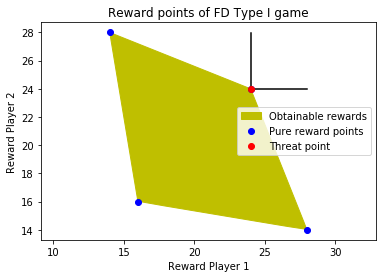

In [24]:
# Here below we create a repeated game from the Llea thesis
a = RepeatedGame(np.matrix('16 14;28 24'),np.matrix('16 28; 14 24'))
a.threat_point_algorithm()
a.plot_pure_reward_points()
a.plot_all_reward_points(False)
a.maximin_algorithm()
a.threat_point_optimized(100000,True,True,True,False)
a.plot_threat_point()
a.plot_threat_point_lines()



# Self build repeated game which contains two pure Nash Equilibriums in which the Pareto inferior option is a threat point
# b = RepeatedGame(np.matrix('6 9; 3 12'),np.matrix('9 6; 12 18'))
# b.threat_point_algorithm()
# b.plot_pure_reward_points()
# b.plot_all_reward_points(False)
# b.plot_threat_point()
# b.maximin_algorithm()

# Self build repeated game containing no pure Nash Equilibria
# c = RepeatedGame(np.matrix('7 2; 6 3'),np.matrix('10 15; 14 13'))
# c.threat_point_algorithm()
# c.plot_pure_reward_points()
# c.plot_all_reward_points(False)
# c.plot_threat_point()
# c.maximin_algorithm()


#Game discussed during meeting with Joosten
# d = RepeatedGame(np.matrix('16 0; 14 24'),np.matrix('16 0; 14 24'))
# d.threat_point_algorithm()
# d.plot_pure_reward_points()
# d.plot_all_reward_points(False)
# d.plot_threat_point()
# d.maximin_algorithm()

#Identity game
# e = RepeatedGame(np.matrix('1 0; 0 1'),np.matrix('1 0; 0 1'))
# e.threat_point_algorithm()
# e.plot_pure_reward_points()
# e.plot_all_reward_points(False)
# e.plot_threat_point()
# e.maximin_algorithm()

# Random game code (disabled by default)
# RandP1 = np.random.randint(25, size=(4,4))
# RandP2 = np.random.randint(25, size=(4,4))

# RandP110 = np.random.randint(25, size=(10,10))
# RandP210 = np.random.randint(25, size=(10,10))

# g = RepeatedGame(RandP1,RandP2)
# g.threat_point_algorithm()
# g.maximin_algorithm()
# g.threat_point_optimized(1000000,False,False,True,False)

# h = RepeatedGame(RandP110,RandP210)
# h.threat_point_algorithm()
# h.maximin_algorithm()
# h.threat_point_optimized(1000000,False,False,True,False)

In [25]:
class StochasticGame:
    """Ïn this class we model Stochastic Games, also known in the thesis as Type II games"""
    
    def __init__(self,payoff_p1_game1,payoff_p2_game1,payoff_p1_game2,payoff_p2_game2,trmatrixg1,trmatrixg2,trmatrixg3,trmatrixg4):
        "Here below we initialize the game by storing payoff and transition matrices according to the upper input."
        self.payoff_p1_game1 = payoff_p1_game1                  #payoff p1 in game 1
        self.payoff_p2_game1 = payoff_p2_game1                  #payoff p2 in game 1
         
        self.payoff_p1_game2 = payoff_p1_game2                  #payoff p1 in game 2
        self.payoff_p2_game2 = payoff_p2_game2                  #payoff p2 in game 2
        
        self.transition_matrix_game1_to1 = trmatrixg1           #transition matrix from game 1 to game 1
        self.transition_matrix_game2_to1 = trmatrixg2           #transition matrix from game 2 to game 1
         
        self.transition_matrix_game1_to2 = trmatrixg3           #transition matrix from game 1 to game 2
        self.transition_matrix_game2_to2 = trmatrixg4           #transition matrix from game 2 to game 2
        
        self.printing = False   #set printing to False
        
    def plot_single_period_pure_rewards(self):
        "Here we plot the pure rewards possible for a single period"
        
        plt.figure()                                            #create a figure
        payoff_p1_g1_flat = self.payoff_p1_game1.A1             #create a flattend payoff of p1 in game 1
        payoff_p2_g1_flat = self.payoff_p2_game1.A1             #create a flattend payoff of p2 in game 1
        plt.scatter(payoff_p1_g1_flat,payoff_p2_g1_flat, label="Pure reward points Game 1", zorder = 15) #plot payoffs game 1
     
        payoff_p1_g2_flat = self.payoff_p1_game2.A1             #create a flattend payoff of p1 in game 2
        payoff_p2_g2_flat = self.payoff_p2_game2.A1             #and for p2 in game 2
        plt.scatter(payoff_p1_g2_flat,payoff_p2_g2_flat, label="Pure reward points Game 2", zorder = 15)  #plotting this again
        
        plt.xlabel("Reward Player 1")                           #giving the x-axis the label of payoff p1
        plt.ylabel("Reward Player 2")                           #and the payoff of the y-axis is that of p2
        plt.title("Reward points of FD Type II game")      #and we give it a nice titel
        plt.legend()
        
    def plot_convex_hull_pure_rewards(self):
        "Here we plot a convex hull around the pure reward point, therefore resulting in the total possible reward space"
        
        payoff_p1_g1_flat = self.payoff_p1_game1.A1       #store the flattend payoff of p1 game 1
        payoff_p2_g1_flat = self.payoff_p2_game1.A1       #store the flattend payoff of p2 game 1
        
        payoff_p1_g2_flat = self.payoff_p1_game2.A1       #store the flattend payoff of p1 game 2
        payoff_p2_g2_flat = self.payoff_p2_game2.A1       #store the flattend payoff of p2 game 2
        
        payoff_p1_merged = np.concatenate((payoff_p1_g1_flat,payoff_p1_g2_flat))  #merge p1 payoffs
        payoff_p2_merged = np.concatenate((payoff_p2_g1_flat,payoff_p2_g2_flat))  #merge p2 payoffs
        
        all_payoffs = np.array([payoff_p1_merged,payoff_p2_merged])  #create one array of payoffs
        all_payoffs = np.transpose(all_payoffs)                      #and rotate this one
        
        rewards_convex_hull = ConvexHull(all_payoffs)                #retain the convex hull of the payoffs
        plt.fill(all_payoffs[rewards_convex_hull.vertices,0], all_payoffs[rewards_convex_hull.vertices,1], color='k')
        plt.title("Convex hull of payoffs")
        
        #here above we fill the convex hull in black

    def plot_threat_point(self):
        "This function plots the threat point of the game" 
        plt.scatter(self.threat_point[0],self.threat_point[1], zorder=10, color = 'r', label='Threat point')
        plt.legend()
        
    
    def plot_threat_point_lines(self):
        "This function plots the threat point lines defining the NE borders"
        
        plt.plot([self.threat_point[0],self.threat_point[0]],[self.threat_point[1],self.maximal_payoffs[1]], color='k', zorder=15)
        plt.plot([self.threat_point[0],self.maximal_payoffs[0]],[self.threat_point[1],self.threat_point[1]], color='k', zorder=15)
        plt.axis('equal')
        plt.savefig('TypeIIFD.png', dpi=400)
        
    def plot_all_reward_points(self,FD_yn):
        "Here we use the algorithm developed in the thesis of Llea with supervision of Joosten for Type 2 games"
        
        ###Payoffs and probabilitys
        payoff_p1_g1_flat = self.payoff_p1_game1.A1          #flatten payoff p1 game 1
        payoff_p2_g1_flat = self.payoff_p2_game1.A1          #flatten payoff p2 game 1
        
        payoff_p1_g2_flat = self.payoff_p1_game2.A1          #flatten payoff p1 game 2
        payoff_p2_g2_flat = self.payoff_p2_game2.A1          #flatten payoff p2 game 2
        
        A1 = np.concatenate((payoff_p1_g1_flat,payoff_p1_g2_flat))   #A1 is payoff Player 1
        B1 = np.concatenate((payoff_p2_g1_flat,payoff_p2_g2_flat))   #B1 is payoff Player 2
        
        trans_game1_1_flat = self.transition_matrix_game1_to1.A1  #flatten transition probabilities game 1 to 1
        trans_game2_1_flat = self.transition_matrix_game2_to1.A1  #flatten transition probabilities game 2 to 1
        
        p = np.concatenate((trans_game1_1_flat,trans_game2_1_flat)) #merge them into one transition array


        ###Intialization of variables
        T = 100000                        #number of points to generate

        x = np.zeros(8)                   #preallocate frequency array
        xstar = np.zeros(8)               #preallocate converged frequency array
        r = np.zeros(8)                   #preallocate random samples from beta distribution
        y = np.zeros(8)                   #preallocate intermediate vector
        yp = np.zeros(4)                  #preallocate intermediate vector with transition
        yp_not = np.zeros(4)              #preallocate intermediate vector with transition
        v_p1 = np.zeros(8)                #preallocate intermediate payoffs p1
        v_p2 = np.zeros(8)                #preallocate intermediate payoffs p2
        payoff_p1 = np.zeros(T)           #preallocate definite payoffs p1
        payoff_p2 = np.zeros(T)           #preallocate definite payoffs p2
        
        for t in range(0,T):              #sum over the number of points to generate
            for i in range(0,8):
                r[i] = np.random.beta(0.5,0.5)      #generate random frequency pair

            for i in range(0,8):
                x[i] = r[i]/np.sum(r)               #normalize the frequency pair so it sums to 1

        ###intermediate calculations (flow equations)
            for i in range(0,4):
                y[i] = x[i]/np.sum(x[0:4])          #calculate intermediate vector

            for i in range(4,8):
                y[i] = x[i]/np.sum(x[4:8])          #see above

            for i in range(0,4):
                yp_not[i] = y[i] * (1-p[i])         #prepare for Q calculations
                yp[i] = y[i+4]*p[i+4]

            Q = np.sum(yp)/(np.sum(yp)+np.sum(yp_not))   #calculate Q and Qnot
            Q_not = 1-Q

        ###Solve for X
            for i in range(0,4):
                xstar[i] = Q*y[i]                   #now calculate converged frequency pairs

            for i in range(4,8):
                xstar[i] = Q_not*y[i]               #and for second game
                
            if FD_yn == True:
                FD = 1-0.25*(xstar[1]+xstar[2])-(1/3)*xstar[3]-(1/2)*(xstar[5] + xstar[6]) - (2/3) * xstar[7]
            else:
                FD = 1 
                
            for i in range(0,8):
                v_p1[i] = xstar[i]*A1[i]            #calculate payoffs player1
                v_p2[i] = xstar[i]*B1[i]            #calculate payoffs player2


        ### Stage payoff vectors
            payoff_p1[t] = FD*np.sum(v_p1)            #result is one payoff of player 1
            payoff_p2[t] = FD*np.sum(v_p2)            #result is one payoff of player 2
            
        all_payoffs = np.array([payoff_p1,payoff_p2])  #payoffs player 1 and and p2 merging
        all_payoffs = np.transpose(all_payoffs)        #transpose for use in convex_hull
        Convex_Hull_Payoffs = ConvexHull(all_payoffs)  #calculate convex_hull of the payoffs
        
        self.maximal_payoffs = np.zeros(2)
        self.maximal_payoffs[0] = np.max(payoff_p1)
        self.maximal_payoffs[1] = np.max(payoff_p2)
        
        #here below we fill the convex_hull of the payoffs and plot it
        plt.fill(all_payoffs[Convex_Hull_Payoffs.vertices,0], all_payoffs[Convex_Hull_Payoffs.vertices,1], color='y', zorder=5, label="Obtainable rewards")
    
    def markov_decision_process_p1(self,x):
        "Here we run the threat point algorithm for P1 with fixed strategy for the punisher and the punished one maximizes this MDP"
        
        def chance_multiplication(self,x):
            "In this function we compute the new transition probabilities based on chosen actions"
            
            # store the actions of the players
            actions_p1_game1 = self.payoff_p1_game1.shape[0]
            actions_p1_game2 = self.payoff_p1_game2.shape[0]            
            actions_p2_game1 = self.payoff_p1_game1.shape[1]
            actions_p2_game2 = self.payoff_p1_game2.shape[1]
            
            length_of_actions = np.max([actions_p1_game1,actions_p1_game2]) # determine the maximum length
            
            p1_combined = np.zeros(length_of_actions, dtype=object) # prepare an object for the probabilities
            
            # in the loop below we calculate the new transition probabilities
            for i in np.nditer(np.arange(length_of_actions)):
                working_probs = np.zeros((2,2))
                
                working_probs[0,0] = np.asscalar(np.dot(self.transition_matrix_game1_to1[i,:],x[0:actions_p2_game1]))
                working_probs[0,1] = np.asscalar(np.dot(self.transition_matrix_game1_to2[i,:],x[0:actions_p2_game1])) 
                working_probs[1,0] = np.asscalar(np.dot(self.transition_matrix_game2_to1[i,:],x[actions_p2_game1:actions_p2_game1+actions_p2_game2]))
                working_probs[1,1] = np.asscalar(np.dot(self.transition_matrix_game2_to2[i,:],x[actions_p2_game1:actions_p2_game1+actions_p2_game2]))
                
                p1_combined[i] = working_probs/np.sum(working_probs,1)

            return p1_combined

        def reward_multiplication(self,x):
            "This function calculates the adjusted rewards"
            
            # initialize empty arrays
            rewards_game1 = []
            rewards_game2 = []
            
            # store the actions for p2
            actions_p2_game1 = self.payoff_p1_game1.shape[1]
            actions_p2_game2 = self.payoff_p1_game2.shape[1]
            
            # calculate the rewards for game 1
            for i in np.nditer(np.arange(self.payoff_p1_game1.shape[0])):
                rewards_game1.append(np.asscalar(np.dot(self.payoff_p1_game1[i,:],x[0:actions_p2_game1])))
            
            # calculate the rewards for game 2
            for i in np.nditer(np.arange(self.payoff_p1_game2.shape[0])):
                rewards_game2.append(np.asscalar(np.dot(self.payoff_p1_game2[i,:],x[actions_p2_game1:actions_p2_game1+actions_p2_game2])))
            
            Reward = np.array([rewards_game1,rewards_game2]) # Combine the rewards in one array
    
            return Reward
        
        p1_combined = chance_multiplication(self,x) # run the transition probability function
        Reward_matrix = reward_multiplication(self,x) # run the rewards function
        
        # Run the MDP process to find the threat point for P1
        mdp_threatpointp1 = mdptoolbox.mdp.RelativeValueIteration(p1_combined, Reward_matrix, epsilon=0.00000000001)
        mdp_threatpointp1.setSilent()
        mdp_threatpointp1.run()

        self.threatpoint_p1_policy = mdp_threatpointp1.policy # store the policy (strategy) found

        if self.printing == True:
            print("Running MDP")
            print("With X as",x)
            print("Resulting in:")
            print(mdp_treatpointp1.average_reward)
            print("With policy:")
            print(mdp_treatpointp1.policy)


        return mdp_threatpointp1.average_reward
        

    def markov_decision_process_p2(self,x):
        "This function creates a MDP for the second player to determine the threat point"
        
        def chance_multiplication(self,x):
            "Calculates the transitions probabilities for the MDP"
            
            # store the actions of the players
            actions_p1_game1 = self.payoff_p1_game1.shape[0]
            actions_p1_game2 = self.payoff_p1_game2.shape[0]            
            actions_p2_game1 = self.payoff_p2_game1.shape[1]
            actions_p2_game2 = self.payoff_p2_game2.shape[1]

            length_of_actions = np.max([actions_p2_game1,actions_p2_game2]) # determine the maximum length of the actions

            p2_combined = np.zeros(length_of_actions, dtype=object) # initialize an object for storing the probabilities
            
            # in this loop we calculate the probabilities and return them
            for i in np.nditer(np.arange(length_of_actions)):
                working_probs = np.zeros((2,2))

                working_probs[0,0] = np.asscalar(np.dot(self.transition_matrix_game1_to1[:,i],x[0:actions_p1_game1]))
                working_probs[0,1] = np.asscalar(np.dot(self.transition_matrix_game1_to2[:,i],x[0:actions_p1_game1])) 
                working_probs[1,0] = np.asscalar(np.dot(self.transition_matrix_game2_to1[:,i],x[actions_p1_game1:actions_p1_game1+actions_p1_game2]))
                working_probs[1,1] = np.asscalar(np.dot(self.transition_matrix_game2_to2[:,i],x[actions_p1_game1:actions_p1_game1+actions_p1_game2]))

                p2_combined[i] = working_probs/np.sum(working_probs,1)

            return p2_combined

        def reward_multiplication(self,x):
            "Calculate the rewards for the game"
            
            # initialize and store the rewards
            rewards_game1 = []
            rewards_game2 = []
            
            # store the actions of p2
            actions_p1_game1 = self.payoff_p2_game1.shape[0]
            actions_p1_game2 = self.payoff_p2_game2.shape[0]
            
            # calculate the rewards of the first game
            for i in np.nditer(np.arange(self.payoff_p1_game1.shape[0])):
                rewards_game1.append(np.asscalar(np.dot(self.payoff_p2_game1[:,i],x[0:actions_p1_game1])))
            
            # calculate the rewards of the second game
            for i in np.nditer(np.arange(self.payoff_p1_game2.shape[0])):
                rewards_game2.append(np.asscalar(np.dot(self.payoff_p2_game2[:,i],x[actions_p1_game1:actions_p1_game1+actions_p1_game2])))

            Reward = np.array([rewards_game1,rewards_game2]) # combine the rewards of both games

            return Reward

        p2_combined = chance_multiplication(self,x) # run the chance function
        Reward2 = reward_multiplication(self,x) # run the rewards function
        
        # Run the MDP for P2 and calculate his threat point
        mdp_threatpointp2 = mdptoolbox.mdp.RelativeValueIteration(p2_combined, Reward2, epsilon=0.00000000001)
        mdp_threatpointp2.setSilent()
        mdp_threatpointp2.run()

        self.threatpoint_p2_policy = mdp_threatpointp2.policy # store the policy of p2 (best strategy)

        if self.printing == True:
            print("Running MDP")
            print("With X as",x)
            print("Resulting in:")
            print(mdp_treatpointp2.average_reward)
            print("With policy:")
            print(mdp_treatpointp2.policy)

        return mdp_threatpointp2.average_reward
       
    def threat_point_algorithm(self,T,sensi):
        "This algorithm calculates the threat point in a two-player game with"
        
        # set the shape of the actions for p1
        x_shape_p1_g1 = self.payoff_p1_game1.shape[0]
        x_shape_p1_g2 = self.payoff_p1_game2.shape[0]
        
        # set the shape of the actions for p2
        x_shape_p2_g1 = self.payoff_p2_game1.shape[1]
        x_shape_p2_g2 = self.payoff_p2_game2.shape[1]
        
        # combine the shapes
        x_shape_p1 = x_shape_p1_g1 + x_shape_p1_g2
        x_shape_p2 = x_shape_p2_g1 + x_shape_p2_g2
        
        # initialiaze the strategies
        xtry = np.zeros(4)
        xtry_p1 = np.zeros(x_shape_p1)
        xtry_p2 = np.zeros(x_shape_p2)
        
        # initialize the MDP values
        tried_mdp_p1 = 0
        stored_value_p1 = 0

        tried_mdp_p2 = 0
        stored_value_p2 = 0
        
        # initialize storage of best threat strategy
        x_best_p1 = np.zeros(x_shape_p1)
        x_best_p2 = np.zeros(x_shape_p2)
        
        new_time = time.time() # start the timer!
            
        for i in np.nditer(np.arange(T)): #loop over the number of to generate points
            
            # generate random strategies for p1 and p2
            xtry_p1 = np.random.beta(0.5,0.5,x_shape_p1)
            xtry_p2 = np.random.beta(0.5,0.5,x_shape_p2)
            
            # normalize these strategies for both p1 and p2
            xtry_p1[0:x_shape_p1_g1] = xtry_p1[0:x_shape_p1_g1]/np.sum(xtry_p1[0:x_shape_p1_g1])
            xtry_p1[x_shape_p1_g1:x_shape_p1] = xtry_p1[x_shape_p1_g1:x_shape_p1]/np.sum(xtry_p1[x_shape_p1_g1:x_shape_p1])
            
            xtry_p2[0:x_shape_p2_g1] = xtry_p2[0:x_shape_p2_g1]/np.sum(xtry_p2[0:x_shape_p2_g1])
            xtry_p2[x_shape_p2_g1:x_shape_p2] = xtry_p2[x_shape_p2_g1:x_shape_p2]/np.sum(xtry_p2[x_shape_p2_g1:x_shape_p2])
            
            # run the MDP for both P1 and P2
            tried_mdp_p1 = self.markov_decision_process_p1(xtry_p1)
            tried_mdp_p2 = self.markov_decision_process_p2(xtry_p2)
            
            if i == 0: # if it is the first run, just store the values
                stored_value_p1 = tried_mdp_p1
                stored_value_p2 = tried_mdp_p2
                x_best_p1 = xtry_p1            
                x_best_p2 = xtry_p2

            else: # if not, check if we have found lower values for both MDP's and store them if so
                if tried_mdp_p1 < stored_value_p1:
                    stored_value_p1 = tried_mdp_p1
                    x_best_p1 = xtry_p1
                    
                elif tried_mdp_p2 < stored_value_p2:
                    stored_value_p2 = tried_mdp_p2
                    x_best_p2 = xtry_p2
        
        # print the preliminary results
        print("Rough value found =",stored_value_p1)
        print("With best threaten strategy:",x_best_p1)

        print("For p2 =",stored_value_p2)
        print("With strategy",x_best_p2)
        print("Found within (seconds): ",time.time() - new_time)
        
        print("")
        print("")
        
        print("Now let's find a more precise point by generating more precise points in an interval")
        print("")
        
        # again initialize the best threat strategies
        updatex_p1 = np.zeros(x_shape_p1)
        updatex_p2 = np.zeros(x_shape_p2)
        
        # loop again for better results
        for i in np.nditer(np.arange(T)):
            
            # calculate updates to the found best threat strategies
            updatex_p1 = x_best_p1-sensi+((x_best_p1+sensi)-x_best_p1)*np.random.beta(0.5,0.5,x_shape_p1)
            updatex_p2 = x_best_p2-sensi+((x_best_p2+sensi)-x_best_p2)*np.random.beta(0.5,0.5,x_shape_p2)
            
            # fail safe in case any action becomes negative
            for j in np.nditer(np.arange(x_shape_p1)):
                if updatex_p1[j] < 0:
                    updatex_p1[j] = -updatex_p1[j]
            
            for j in np.nditer(np.arange(x_shape_p2)):
                if updatex_p2[j] < 0:
                    updatex_p2[j] = -updatex_p2[j]
            
            # normalize the strategies
            updatex_p1[0:x_shape_p1_g1] = updatex_p1[0:x_shape_p1_g1]/np.sum(updatex_p1[0:x_shape_p1_g1])
            updatex_p1[x_shape_p1_g1:x_shape_p1] = updatex_p1[x_shape_p1_g1:x_shape_p1]/np.sum(updatex_p1[x_shape_p1_g1:x_shape_p1])

            updatex_p2[0:x_shape_p2_g1] = updatex_p2[0:x_shape_p2_g1]/np.sum(updatex_p2[0:x_shape_p2_g1])
            updatex_p2[x_shape_p2_g1:x_shape_p2] = updatex_p2[x_shape_p2_g1:x_shape_p2]/np.sum(updatex_p2[x_shape_p2_g1:x_shape_p2])
            
            # run the MDP for new chosen strategies
            new_try_mdp_p1 = self.markov_decision_process_p1(updatex_p1)
            new_try_mdp_p2 = self.markov_decision_process_p2(updatex_p2)
            
            # if new found values are lower then store them
            if new_try_mdp_p1 < stored_value_p1:
                stored_value_p1 = new_try_mdp_p1
                x_best_p1 = updatex_p1

            elif new_try_mdp_p2 < stored_value_p2:
                stored_value_p2 = new_try_mdp_p2
                x_best_p2 = updatex_p2


        # print the threat point
        print("New value found =",stored_value_p1)
        print("With best strategy =",x_best_p1)
        print("")
        print("For p2 =",stored_value_p2)
        print("With strategy",x_best_p2)
        print("")
        print("")
        print("End of algorithm")
        print("")
        print("")

        self.threat_point = [stored_value_p1,stored_value_p2] # store the threat point
   
    def markov_try_out_max_p1(self,x):
        "Maximize the payoff by using negative values"
        
        def chance_multiplication(self,x):
            "This function calculates the transition probabilities"
            
            # this function stores the actions of the players
            actions_p1_game1 = self.payoff_p1_game1.shape[0]
            actions_p1_game2 = self.payoff_p1_game2.shape[0]            
            actions_p2_game1 = self.payoff_p2_game1.shape[1]
            actions_p2_game2 = self.payoff_p2_game2.shape[1]

            length_of_actions = np.max([actions_p2_game1,actions_p2_game2]) # determine the maximum length of the actions

            p2_combined = np.zeros(length_of_actions, dtype=object) # initialize an empty object
            
            # calculate the transition probabilities based on chosen actions
            for i in np.nditer(np.arange(length_of_actions)):
                working_probs = np.zeros((2,2))

                working_probs[0,0] = np.asscalar(np.dot(self.transition_matrix_game1_to1[:,i],x[0:actions_p1_game1]))
                working_probs[0,1] = np.asscalar(np.dot(self.transition_matrix_game1_to2[:,i],x[0:actions_p1_game1])) 
                working_probs[1,0] = np.asscalar(np.dot(self.transition_matrix_game2_to1[:,i],x[actions_p1_game1:actions_p1_game1+actions_p1_game2]))
                working_probs[1,1] = np.asscalar(np.dot(self.transition_matrix_game2_to2[:,i],x[actions_p1_game1:actions_p1_game1+actions_p1_game2]))

                p2_combined[i] = working_probs/np.sum(working_probs,1)

            return p2_combined    
    
        
        p2_combined_max = chance_multiplication(self,x) # run the chance multiplication function
        
        def reward_multiplication(self,x):
            "This function computes the reward matrix based on the input strategy"
            
            # initialize the reewards for game 1 and game 2
            rewards_game1 = []
            rewards_game2 = []
            
            # store the actions for p1 in game 1 and 2
            actions_p1_game1 = self.payoff_p1_game1.shape[0]
            actions_p1_game2 = self.payoff_p1_game2.shape[0]
            
            # calculate the new rewards for game 1
            for i in np.nditer(np.arange(self.payoff_p1_game1.shape[0])):
                rewards_game1.append(np.asscalar(-np.dot(self.payoff_p1_game1[:,i],x[0:actions_p1_game1])))
            
            # calculate the new rewards for game 2
            for i in np.nditer(np.arange(self.payoff_p1_game2.shape[0])):
                rewards_game2.append(np.asscalar(-np.dot(self.payoff_p1_game2[:,i],x[actions_p1_game1:actions_p1_game1+actions_p1_game2])))

            Reward = np.array([rewards_game1,rewards_game2]) # store them in one array

            return Reward
        
        Reward2_max = reward_multiplication(self,x) # run the reward function
        
        # run the MDP which computes the minimax for p1
        mdp_threatpoint_minp1 = mdptoolbox.mdp.RelativeValueIteration(p2_combined_max, Reward2_max, epsilon=0.00000000001)
        mdp_threatpoint_minp1.setSilent()
        mdp_threatpoint_minp1.run()

        self.threatpoint_p1_min_policy = mdp_threatpoint_minp1.policy # store the policy
        
        # print the result
        if self.printing == True:
            print("Running MDP")
            print("With X as",x)
            print("Resulting in:")
            print(mdp_treatpoint_minp1.average_reward)
            print("With policy:")
            print(mdp_treatpoint_minp1.policy)

        return mdp_threatpoint_minp1.average_reward
        
    def markov_try_out_max_p2(self,x):
        "The maximin version of the MDP for P2"
        
        def chance_multiplication(self,x):
            "The transition probability function"
            
            # store the actions for both players
            actions_p1_game1 = self.payoff_p1_game1.shape[0]
            actions_p1_game2 = self.payoff_p1_game2.shape[0]            
            actions_p2_game1 = self.payoff_p1_game1.shape[1]
            actions_p2_game2 = self.payoff_p1_game2.shape[1]
            
            length_of_actions = np.max([actions_p1_game1,actions_p1_game2]) # select the maximal length of the actions
            
            p1_combined = np.zeros(length_of_actions, dtype=object) # initialize the p1 transition probability
            
            # calculate the transition probabilities for p1
            for i in np.nditer(np.arange(length_of_actions)):
                working_probs = np.zeros((2,2))
                
                working_probs[0,0] = np.asscalar(np.dot(self.transition_matrix_game1_to1[i,:],x[0:actions_p2_game1]))
                working_probs[0,1] = np.asscalar(np.dot(self.transition_matrix_game1_to2[i,:],x[0:actions_p2_game1])) 
                working_probs[1,0] = np.asscalar(np.dot(self.transition_matrix_game2_to1[i,:],x[actions_p2_game1:actions_p2_game1+actions_p2_game2]))
                working_probs[1,1] = np.asscalar(np.dot(self.transition_matrix_game2_to2[i,:],x[actions_p2_game1:actions_p2_game1+actions_p2_game2]))
                
                p1_combined[i] = working_probs/np.sum(working_probs,1)

            return p1_combined
        
        def reward_multiplication(self,x):
            "Multiply the rewards for p2's maximin"
            
            # initialize the array for storage
            rewards_game1 = []
            rewards_game2 = []
            
            # store the actions for p2 in both games
            actions_p2_game1 = self.payoff_p2_game1.shape[1]
            actions_p2_game2 = self.payoff_p2_game2.shape[1]
            
            # compute the rewards for game 1
            for i in np.nditer(np.arange(self.payoff_p2_game1.shape[0])):
                rewards_game1.append(-np.asscalar(np.dot(self.payoff_p2_game1[i,:],x[0:actions_p2_game1])))
            
            # compute the rewards for game 2
            for i in np.nditer(np.arange(self.payoff_p1_game2.shape[0])):
                rewards_game2.append(-np.asscalar(np.dot(self.payoff_p2_game2[i,:],x[actions_p2_game1:actions_p2_game1+actions_p2_game2])))
        
            Reward = np.array([rewards_game1,rewards_game2]) # combine the rewards in one array
    
            return Reward
    
        p1_combined = chance_multiplication(self,x) # compute the new transition probabilities
        Reward = reward_multiplication(self,x) # compute the new rewards
        
        # run the MDP to compute the maximin for p2
        mdp_threatpointp1 = mdptoolbox.mdp.RelativeValueIteration(p1_combined, Reward, epsilon=0.00000000001)
        mdp_threatpointp1.setSilent()
        mdp_threatpointp1.run()

        self.threatpoint_p1_policy = mdp_threatpointp1.policy #store the policy
        
        # print some blabla (wonder if someone ever reads this)
        if self.printing == True:
            print("Running MDP")
            print("With X as",x)
            print("Resulting in:")
            print(mdp_treatpointp1.average_reward)
            print("With policy:")
            print(mdp_treatpointp1.policy)


        return mdp_threatpointp1.average_reward
    
    def maximin_point(self,T):
        "This part tries to find the maximin point for T points"
        print("Trying to find the maximin values for both players")
        
        # store the shape of the games for both players
        x_shape_p1_g1 = self.payoff_p1_game1.shape[0]
        x_shape_p1_g2 = self.payoff_p1_game2.shape[0]
        
        x_shape_p2_g1 = self.payoff_p2_game1.shape[1]
        x_shape_p2_g2 = self.payoff_p2_game2.shape[1]
        
        # add up the shapes for both players
        x_shape_p1 = x_shape_p1_g1 + x_shape_p1_g2
        x_shape_p2 = x_shape_p2_g1 + x_shape_p2_g2
        
        # initialize for trying strategies
        x_try_p1_max = np.zeros(x_shape_p2)
        x_try_p2_max = np.zeros(x_shape_p1)
        
        # set all 'found' values to zero
        tried_mdp_p1_max = 0
        stored_value_p1_max = 0

        tried_mdp_p2_max = 0
        stored_value_p2_max = 0
        
        # loop over the number of points to generate
        for i in range(0,T):
                
            # draw new strategies
            x_try_p1_max = np.random.beta(0.5,0.5,x_shape_p2)
            x_try_p2_max = np.random.beta(0.5,0.5,x_shape_p1)
            
            # normalize these strategies
            x_try_p1_max[0:x_shape_p2_g1] = x_try_p1_max[0:x_shape_p2_g1]/np.sum(x_try_p1_max[0:x_shape_p2_g1])
            x_try_p1_max[x_shape_p2_g1:x_shape_p2] = x_try_p1_max[x_shape_p2_g1:x_shape_p2]/np.sum(x_try_p1_max[x_shape_p2_g1:x_shape_p2])
            
            x_try_p2_max[0:x_shape_p1_g1] = x_try_p2_max[0:x_shape_p1_g1]/np.sum(x_try_p2_max[0:x_shape_p1_g1])
            x_try_p2_max[x_shape_p1_g1:x_shape_p1] = x_try_p2_max[x_shape_p1_g1:x_shape_p1]/np.sum(x_try_p2_max[x_shape_p1_g1:x_shape_p1])

            # run the markov maximin problems
            tried_mdp_p1_max = -self.markov_try_out_max_p1(x_try_p1_max)
            tried_mdp_p2_max = -self.markov_try_out_max_p2(x_try_p2_max)

            # if it is the first result, store it
            if i == 0:
                stored_value_p1_max = tried_mdp_p1_max
                stored_value_p2_max = tried_mdp_p2_max

                x_best_p1_max = x_try_p1_max
                x_best_p2_max = x_try_p2_max
            
            # if a higher value is found and it is not the first result, then store again
            else:
                if tried_mdp_p1_max > stored_value_p1_max:
                    stored_value_p1_max = tried_mdp_p1_max
                    x_best_p1_max = x_try_p1_max
                if tried_mdp_p2_max > stored_value_p2_max:
                    stored_value_p2_max = tried_mdp_p2_max
                    x_best_p2_max = x_try_p2_max

        print("Maximin value found for P1",stored_value_p1_max)
        print("With best maximization strategy:",x_best_p1_max)       
        print("")
        print("Maximin value found for P2",stored_value_p2_max)
        print("With best maximization strategy:",x_best_p2_max)
        print("")
        print("")    
        
    def optimized_maximin(self,points,show_strat_p1,show_strat_p2,FD_yn):
        "This algorithim is a more optimized way of calculating the maximin results "
        print("Start of the maximin algorithm")        
        
        def random_strategy_draw(points,number_of_actions):
            "This function draws random strategies from a beta distribution, based on the number of points and actions"
            
            # draw the strategies and normalize them
            strategies_drawn = np.random.beta(0.5,0.5,(points,number_of_actions))
            strategies_drawn = strategies_drawn/np.sum(strategies_drawn, axis=1).reshape([points,1])
            
            return strategies_drawn
        
        def frequency_pairs_p1(points,p2_actions,p1_actions,strategies_drawn):
            "This function sorts the strategies that punish based on the best replies for p1"
            
            # store the size of the game
            game_size_1 = self.payoff_p1_game1.size
            game_size_2 = self.payoff_p1_game2.size
            
            # store the actions of the game
            p1_actions_game1 = self.payoff_p1_game1.shape[0]
            p1_actions_game2 = self.payoff_p1_game2.shape[0]
            
            # calculate the combination of actions and set it in a range
            p1_actions_combi = p1_actions_game1*p1_actions_game2
            p1_action_range = np.arange(p1_actions_combi)
            
            # initialize a frequency pair
            frequency_pairs = np.zeros((points*(p1_actions_game1*p1_actions_game2),game_size_1+game_size_2))
            
            # set ranges for game 1 and 2
            p1_act_game1_range = np.arange(p1_actions_game1)
            p1_act_game2_range = np.arange(p1_actions_game2)
            
            # set the frequency pairs for game 1 based on best replies
            for i in np.nditer(p1_action_range):
                for j in np.nditer(p1_act_game1_range):
                    mod_remain = np.mod(i,p1_actions_game1)
                    frequency_pairs[i*points:(i+1)*points,p1_actions_game1*mod_remain+j] = strategies_drawn[:,j]
            
            # set the frequency pairs for game 2 based on best replies
            for i in np.nditer(p1_action_range):
                for j in np.nditer(p1_act_game2_range):
                    floor_div = np.floor_divide(i,p1_actions_game2)
                    frequency_pairs[i*points:(i+1)*points,j+game_size_1+(p1_actions_game1*floor_div)] = strategies_drawn[:,p1_actions_game1+j]

            return frequency_pairs
        
        def balance_equation(self,tot_act_ut,tot_act_thr,tot_payoffs_game1,tot_payoffs,frequency_pairs):
            "Calculates the result of the balance equations in order to adjust the frequency pairs"
            
            # store the game size
            game_size_1 = self.payoff_p1_game1.size
            game_size_2 = self.payoff_p1_game2.size
            
            # initialize yi and Q
            yi = np.zeros((points*(tot_act_thr*tot_act_ut),game_size_1+game_size_2))
            Q = np.zeros((1,points*(tot_act_thr*tot_act_ut)))
            
            # calculate yi
            yi[:,0:tot_payoffs_game1] = frequency_pairs[:,0:tot_payoffs_game1]/np.sum(frequency_pairs[:,0:tot_payoffs_game1], axis=1).reshape([points*tot_payoffs_game1,1])
            yi[:,tot_payoffs_game1:tot_payoffs] = frequency_pairs[:,tot_payoffs_game1:tot_payoffs]/np.sum(frequency_pairs[:,tot_payoffs_game1:tot_payoffs], axis=1).reshape([points*(tot_payoffs-tot_payoffs_game1),1])
            
            # store px
            p1_px_between = np.asarray(px)
            p1_px = p1_px_between[0]
            
            # calculate Q
            Q[0,:] = (np.sum(yi[:,tot_payoffs_game1:tot_payoffs]*p1_px[tot_payoffs_game1:tot_payoffs],axis=1))/((np.dot(yi[:,0:tot_payoffs_game1],(1-p1_px[0:tot_payoffs_game1]))+np.dot(yi[:,tot_payoffs_game1:tot_payoffs],p1_px[tot_payoffs_game1:tot_payoffs])))
            
            # calculate new frequency pairs based on Q
            frequency_pairs[:,0:tot_payoffs_game1] = (np.multiply(Q.transpose(),yi[:,0:tot_payoffs_game1]))
            frequency_pairs[:,tot_payoffs_game1:tot_payoffs] = np.multiply((1-Q.transpose()),yi[:,tot_payoffs_game1:tot_payoffs])
            
            return frequency_pairs
        
        def frequency_pairs_p2(points,p2_actions,p1_actions,strategies_drawn):
            "This function sorts the punish strategies based on the best replies of p2"
            
            # store the game size
            game_size_1 = self.payoff_p2_game1.size
            game_size_2 = self.payoff_p2_game2.size
            
            # create a range of actions of both players
            p1_actions_range = np.arange(p1_actions)
            p2_actions_range = np.arange(p2_actions)
            
            # store the shape of the both games
            p2_actions_game1 = self.payoff_p2_game1.shape[1]
            p2_actions_game2 = self.payoff_p2_game2.shape[1]
            
            # calculate the range of possible actions
            p2_actions_combo = p2_actions_game1*p2_actions_game2
            p2_action_range = np.arange(p2_actions_combo)
            
            # initialize the frequency pairs
            frequency_pairs = np.zeros((points*(p2_actions_game1*p2_actions_game2),game_size_1+game_size_2))
            
            # sort the frequency pairs for the first game
            for i in np.nditer(np.arange(p2_actions_game1)):
                for j in np.nditer(p2_action_range):
                    modul = np.mod(j,p2_actions_game1)
                    frequency_pairs[j*points:(j+1)*points,p2_actions_game1*i+modul] = strategies_drawn[:,i]
            
            # sort the frequency pairs for the second game
            for i in np.nditer(np.arange(p2_actions_game2)):
                for j in np.nditer(p2_action_range):
                    divide = np.floor_divide(j,p2_actions_game2)
                    frequency_pairs[j*points:(j+1)*points,p2_actions_combo+divide+(i*p2_actions_game2)] = strategies_drawn[:,i+p2_actions_game1]                 
                    
            return frequency_pairs
        
        def payoffs_sorted(points,payoffs,actions):
            "Sort the payoffs for use on the max and min functions"
            
            # create two ranges based on the number of points and actions
            points_range = np.arange(points)
            actions_range = np.arange(actions)
        
            payoffs_sort = np.zeros((points,actions)) # initialize the payoff_sort array
            
            # sort the payoffs
            for x in np.nditer(points_range):
                for i in np.nditer(actions_range):
                    payoffs_sort[x,i] = payoffs[points*i+x]
            
            return payoffs_sort
        
        ## Start of p1 maximin ##
        
        start_time = time.time() # start the time!
        
        # flatten the transition matrices
        flatten1_1 = self.transition_matrix_game1_to1.flatten()
        flatten2_1 = self.transition_matrix_game2_to1.flatten()
        
        # save and compute the total number of actions
        actions_p2_game1 = self.payoff_p1_game1.shape[1]
        actions_p2_game2 = self.payoff_p1_game2.shape[1]
        total_actions_p2 = actions_p2_game1 + actions_p2_game2
    
        actions_p1_game1 = self.payoff_p1_game1.shape[0]
        actions_p1_game2 = self.payoff_p1_game2.shape[0]
        total_actions_p1 = actions_p1_game1 + actions_p1_game2
        
        # flatten the payoffs
        payoff_p1_game_1flatten = self.payoff_p1_game1.flatten()
        payoff_p1_game_2flatten = self.payoff_p1_game2.flatten()
        
        total_payoffs_p1_game1 = payoff_p1_game_1flatten.size
        total_payoffs_p1_game2 = payoff_p1_game_2flatten.size
        total_payoffs_p1 = total_payoffs_p1_game1 + total_payoffs_p1_game2
        
        # initialize and assign the payoffs for p1
        payoff_p1 = np.zeros(total_payoffs_p1)
        payoff_p1[0:total_payoffs_p1_game1] = payoff_p1_game_1flatten
        payoff_p1[total_payoffs_p1_game1:total_payoffs_p1] = payoff_p1_game_2flatten

        px = np.concatenate([flatten1_1,flatten2_1],axis=1) # create px
        
        y_punisher = random_strategy_draw(points,total_actions_p1) # draw random strategies for the punisher

        frequency_pairs = frequency_pairs_p2(points,total_actions_p1,total_actions_p2,y_punisher) # sort these 
        
        # run the balance equation
        frequency_pairs = balance_equation(self,actions_p2_game1,actions_p2_game2,total_payoffs_p1_game1,total_payoffs_p1,frequency_pairs)
        
        # if the FD_function is available, run this (note: Only the FD function from the thesis)
        if FD_yn == True:
            FD = 1-0.25*(frequency_pairs[:,1]+frequency_pairs[:,2])-(1/3)*frequency_pairs[:,3]-(1/2)*(frequency_pairs[:,5] + frequency_pairs[:,6]) - (2/3) * frequency_pairs[:,7]
        else:
            FD = 1  
        
        # calculate the payoffs with multiplication of payoffs and Fd function
        payoffs = np.sum(np.multiply(frequency_pairs,payoff_p1),axis=1)
        payoffs = np.multiply(FD,payoffs)
        payoffs = payoffs.reshape((payoffs.size,1))

        max_payoffs = payoffs_sorted(points,payoffs,(actions_p2_game1*actions_p2_game2)) # sort the payoffs
        
        print("")
        print("")
        minimax_found = np.max(np.min(max_payoffs,axis=1))
        print("Maximin value for P1 is",minimax_found)
        print("")
        print("")
        
        # print the results
        if show_strat_p1 == True:
            minimax_indices_p2 = np.where(max_payoffs == minimax_found)
            found_strategy_p2 = y_punisher[minimax_indices_p2[0]]
            fnd_strategy_p2 = found_strategy_p2.flatten()
            fnd_strategy_p2[0:2] = fnd_strategy_p2[0:2]/np.sum(fnd_strategy_p2[0:2])
            fnd_strategy_p2[2:4] = fnd_strategy_p2[2:4]/np.sum(fnd_strategy_p2[2:4])
            print("Player 1 plays stationary strategy:", fnd_strategy_p2)
            print("While player 2 replies with a best pure reply of:", self.best_pure_strategies[minimax_indices_p2[1]])
            
        end_time = time.time() # stop the time!
        print("Seconds done to generate", points, "points", end_time-start_time)
        
        ## End of P1 maximin algorithm ##
        
        start_time_p2 = time.time() # start the time (Again!)
        
        #flatten the payoffs
        payoff_p2_game_1flatten = self.payoff_p2_game1.flatten()
        payoff_p2_game_2flatten = self.payoff_p2_game2.flatten()
        
        # store and compute the total payoffs
        total_payoffs_p2_game1 = payoff_p2_game_1flatten.size
        total_payoffs_p2_game2 = payoff_p2_game_2flatten.size
        total_payoffs_p2 = total_payoffs_p2_game1 + total_payoffs_p2_game2
        
        # initialize and assign the payoffs for p2
        payoff_p2 = np.zeros(total_payoffs_p2)
        payoff_p2[0:total_payoffs_p2_game1] = payoff_p2_game_1flatten
        payoff_p2[total_payoffs_p2_game1:total_payoffs_p2] = payoff_p2_game_2flatten

        px = np.concatenate([flatten1_1,flatten2_1],axis=1) # store px

        x_punisher = random_strategy_draw(points,total_actions_p2) # draw punisher strategies
        
        frequency_pairs = frequency_pairs_p1(points,total_actions_p1,total_actions_p2,x_punisher) # best replies
        
        # do the balance equation trick
        frequency_pairs = balance_equation(self,actions_p1_game1,actions_p1_game2,total_payoffs_p1_game1,total_payoffs_p1,frequency_pairs)
        
        # if the FD function is on, then run it
        if FD_yn == True:
            FD = 1-0.25*(frequency_pairs[:,1]+frequency_pairs[:,2])-(1/3)*frequency_pairs[:,3]-(1/2)*(frequency_pairs[:,5] + frequency_pairs[:,6]) - (2/3) * frequency_pairs[:,7]
        else:
            FD = 1     
        
        # compute the payoffs with the payoffs and FD function
        payoffs = np.sum(np.multiply(frequency_pairs,payoff_p2),axis=1)
        
        payoffs = np.multiply(FD,payoffs)
        payoffs = payoffs.reshape((payoffs.size,1))
        
        max_payoffs = payoffs_sorted(points,payoffs,(actions_p1_game1*actions_p1_game2))     # sort the payoffs    

        print("")
        print("")
        minimax_found_p2 = np.max(np.min(max_payoffs,axis=1)) # find the maximin value
        print("Maximin value for P2 is",minimax_found_p2)
        print("")
        print("")
        
        # print the strategies
        if show_strat_p2 == True:
            maximin_indices_p2 = np.where(max_payoffs == minimax_found_p2)
            found_strategy = x_punisher[maximin_indices_p2[0]]
            fnd_strategy = found_strategy.flatten()
            fnd_strategy[0:2] = fnd_strategy[0:2]/np.sum(fnd_strategy[0:2])
            fnd_strategy[2:4] = fnd_strategy[2:4]/np.sum(fnd_strategy[2:4])
            print("Player 2 plays stationairy strategy:", fnd_strategy)
            print("While player 2 replies with a best pure reply of:", self.best_pure_strategies[maximin_indices_p2[1]])
        
        end_time_p2 = time.time() # stop the time
        print("Seconds done to generate", points, "points", end_time_p2-start_time_p2)
        print("")
        print("")
        
    def threat_point_optimized(self,points,show_strat_p1,show_strat_p2,print_text,FD_yn):
        "The optimized, super awesome threat point algorithm!"
        
        def random_strategy_draw(points,number_of_actions):
            "This function draws random strategies from a beta distribution, based on the number of points and actions"
            
            # draw the strategies and normalize them
            strategies_drawn = np.random.beta(0.5,0.5,(points,number_of_actions))
            strategies_drawn = strategies_drawn/np.sum(strategies_drawn, axis=1).reshape([points,1])
            
            return strategies_drawn
        
        def frequency_pairs_p1(points,p2_actions,p1_actions,strategies_drawn):
            "This function sorts the punisher strategies based on the replies for p1"
            
            # store the game sizes
            game_size_1 = self.payoff_p1_game1.size
            game_size_2 = self.payoff_p1_game2.size
            
            # store the actions of p1 for both games
            p1_actions_game1 = self.payoff_p1_game1.shape[0]
            p1_actions_game2 = self.payoff_p1_game2.shape[0]
            
            # set both actions within a certain range
            p1_actions_combi = p1_actions_game1*p1_actions_game2
            p1_action_range = np.arange(p1_actions_combi)
            
            # initialize the frequency pair
            frequency_pairs = np.zeros((points*(p1_actions_game1*p1_actions_game2),game_size_1+game_size_2))
            
            # set action ranges for both games
            p1_act_game1_range = np.arange(p1_actions_game1)
            p1_act_game2_range = np.arange(p1_actions_game2)
            
            # set the best replies for the first game
            for i in np.nditer(p1_action_range):
                for j in np.nditer(p1_act_game1_range):
                    mod_remain = np.mod(i,p1_actions_game1)
                    frequency_pairs[i*points:(i+1)*points,p1_actions_game1*mod_remain+j] = strategies_drawn[:,j]
            
            # set the best replies for the second game
            for i in np.nditer(p1_action_range):
                for j in np.nditer(p1_act_game2_range):
                    floor_div = np.floor_divide(i,p1_actions_game2)
                    frequency_pairs[i*points:(i+1)*points,j+game_size_1+(p1_actions_game1*floor_div)] = strategies_drawn[:,p1_actions_game1+j]
            
            return frequency_pairs
        
        def balance_equation(self,tot_act_ut,tot_act_thr,tot_payoffs_game1,tot_payoffs,frequency_pairs):
            "Calculates the result of the balance equations in order to adjust the frequency pairs"
            
            # store size of game 1 and 2
            game_size_1 = self.payoff_p1_game1.size
            game_size_2 = self.payoff_p1_game2.size
            
            # initialize yi and Q
            yi = np.zeros((points*(tot_act_thr*tot_act_ut),game_size_1+game_size_2))
            Q = np.zeros((1,points*(tot_act_thr*tot_act_ut)))
            
            # compute Yi
            yi[:,0:tot_payoffs_game1] = frequency_pairs[:,0:tot_payoffs_game1]/np.sum(frequency_pairs[:,0:tot_payoffs_game1], axis=1).reshape([points*tot_payoffs_game1,1])
            yi[:,tot_payoffs_game1:tot_payoffs] = frequency_pairs[:,tot_payoffs_game1:tot_payoffs]/np.sum(frequency_pairs[:,tot_payoffs_game1:tot_payoffs], axis=1).reshape([points*(tot_payoffs-tot_payoffs_game1),1])
            
            p1_px_between = np.asarray(px) # some tricks with px  (ha-ha)
            p1_px = p1_px_between[0]

            # compute Q
            Q[0,:] = (np.sum(yi[:,tot_payoffs_game1:tot_payoffs]*p1_px[tot_payoffs_game1:tot_payoffs],axis=1))/((np.dot(yi[:,0:tot_payoffs_game1],(1-p1_px[0:tot_payoffs_game1]))+np.dot(yi[:,tot_payoffs_game1:tot_payoffs],p1_px[tot_payoffs_game1:tot_payoffs])))
            
            # adjust the frequency pairs based on Q
            frequency_pairs[:,0:tot_payoffs_game1] = (np.multiply(Q.transpose(),yi[:,0:tot_payoffs_game1]))
            frequency_pairs[:,tot_payoffs_game1:tot_payoffs] = np.multiply((1-Q.transpose()),yi[:,tot_payoffs_game1:tot_payoffs])
            
            return frequency_pairs
        
        def frequency_pairs_p2(points,p2_actions,p1_actions,strategies_drawn):
            "This function sorts the punisher strategies based on the replies for p2"
            
            # store the sizes of both games
            game_size_1 = self.payoff_p2_game1.size
            game_size_2 = self.payoff_p2_game2.size
            
            # make a nice range of the actions for both players and store them
            p1_actions_range = np.arange(p1_actions)
            p2_actions_range = np.arange(p2_actions)
            
            p2_actions_game1 = self.payoff_p2_game1.shape[1]
            p2_actions_game2 = self.payoff_p2_game2.shape[1]
            
            p2_actions_combo = p2_actions_game1*p2_actions_game2
            p2_action_range = np.arange(p2_actions_combo)
            
            # initialize the frequency pairs
            frequency_pairs = np.zeros((points*(p2_actions_game1*p2_actions_game2),game_size_1+game_size_2))
            
            # loop over the first games best responses
            for i in np.nditer(np.arange(p2_actions_game1)):
                for j in np.nditer(p2_action_range):
                    modul = np.mod(j,p2_actions_game1)
                    frequency_pairs[j*points:(j+1)*points,p2_actions_game1*i+modul] = strategies_drawn[:,i]
            
            # loop over the second games best responses
            for i in np.nditer(np.arange(p2_actions_game2)):
                for j in np.nditer(p2_action_range):
                    divide = np.floor_divide(j,p2_actions_game2)
                    frequency_pairs[j*points:(j+1)*points,p2_actions_combo+divide+(i*p2_actions_game2)] = strategies_drawn[:,i+p2_actions_game1]
                    
            return frequency_pairs
        
        def payoffs_sorted(points,payoffs,actions):
            "This function sorts the payoffs for use on the threat point function"
            
            # set a points and actions range
            points_range = np.arange(points)
            actions_range = np.arange(actions)
        
            payoffs_sort = np.zeros((points,actions)) # initialize the payoffs sorted
             
            # and sort them in a loop
            for x in np.nditer(points_range):
                for i in np.nditer(actions_range):
                    payoffs_sort[x,i] = payoffs[points*i+x]
            
            return payoffs_sort
        
        if print_text == True:
            print("The start of the algorithm for finding the threat point")
            print("First let's find the threat point for Player 1")

        # flatten the transition probabilities
        flatten1_1 = self.transition_matrix_game1_to1.flatten()
        flatten2_1 = self.transition_matrix_game2_to1.flatten()
        
        # store the actions of both players
        actions_p2_game1 = self.payoff_p1_game1.shape[1]
        actions_p2_game2 = self.payoff_p1_game2.shape[1]
        total_actions_p2 = actions_p2_game1 + actions_p2_game2
        
        actions_p1_game1 = self.payoff_p1_game1.shape[0]
        actions_p1_game2 = self.payoff_p1_game2.shape[0]
        total_actions_p1 = actions_p1_game1 + actions_p1_game2
        
        # Start of algorithm for player 1
        
        start_time = time.time() # and start the time!
        
        # flatten the payoffs of both players
        payoff_p1_game_1flatten = self.payoff_p1_game1.flatten()
        payoff_p1_game_2flatten = self.payoff_p1_game2.flatten()
        
        total_payoffs_p1_game1 = payoff_p1_game_1flatten.size
        total_payoffs_p1_game2 = payoff_p1_game_2flatten.size
        total_payoffs_p1 = total_payoffs_p1_game1 + total_payoffs_p1_game2
        
        # initialize and assign the payoffs for p1
        payoff_p1 = np.zeros(total_payoffs_p1)
        payoff_p1[0:total_payoffs_p1_game1] = payoff_p1_game_1flatten
        payoff_p1[total_payoffs_p1_game1:total_payoffs_p1] = payoff_p1_game_2flatten
        
        px = np.concatenate([flatten1_1,flatten2_1],axis=1) # create px
        
        y_punisher = random_strategy_draw(points,total_actions_p2) #  draw strategies for the punisher
              
        frequency_pairs = frequency_pairs_p1(points,total_actions_p2,total_actions_p1,y_punisher) # sort based on best replies
        
        # calculate the adjustments based on the balance equation
        frequency_pairs = balance_equation(self,actions_p1_game1,actions_p1_game2,total_payoffs_p1_game1,total_payoffs_p1,frequency_pairs)
        
        # if FD function is activated, activate it
        if FD_yn == True:
            FD = 1-0.25*(frequency_pairs[:,1]+frequency_pairs[:,2])-(1/3)*frequency_pairs[:,3]-(1/2)*(frequency_pairs[:,5] + frequency_pairs[:,6]) - (2/3) * frequency_pairs[:,7]
        else:
            FD = 1  
        
        # calculate the payoffs based on the frequency pairs and FD function
        payoffs = np.sum(np.multiply(frequency_pairs,payoff_p1),axis=1)
        payoffs = np.multiply(FD,payoffs)
        payoffs = payoffs.reshape((payoffs.size,1))
        
        max_payoffs = payoffs_sorted(points,payoffs,(actions_p1_game1*actions_p1_game2)) # sort the payoffs

        threat_point_p1 = np.min(np.max(max_payoffs,axis=1)) # determine the threat point
        
        if print_text == True:
            print("")
            print("")
            print("Threat point value is",threat_point_p1)
            print("")
            print("")
        
        if show_strat_p1 == True:
            threat_point_indices_p1 = np.where(max_payoffs == threat_point_p1)
            found_strategy_p1 = y_punisher[threat_point_indices_p1[0]]
            fnd_strategy_p1 = found_strategy_p1.flatten()
            fnd_strategy_p1[0:2] = fnd_strategy_p1[0:2]/np.sum(fnd_strategy_p1[0:2])
            fnd_strategy_p1[2:4] = fnd_strategy_p1[2:4]/np.sum(fnd_strategy_p1[2:4])
            print("Player 2 plays stationary strategy:", fnd_strategy_p1)
            print("While player 1 replies with a best pure reply of:", self.best_pure_strategies[threat_point_indices_p1[1]])
            
        end_time = time.time() # stop the time!
        
        if print_text == True:
            print("Seconds done to generate", points, "points", end_time-start_time)
            print("")
        
        # End of algorithm player 1
        
        # Start of algorithm player 2
        
        if print_text == True:
            print("")
            print("")
            print("First start the threat point for player 2")
        start_time_p2 = time.time() # new timer, new times
        
        # flatten the payoffs for p2
        payoff_p2_game_1flatten = self.payoff_p2_game1.flatten()
        payoff_p2_game_2flatten = self.payoff_p2_game2.flatten()
        
        # assign tha payoffs for p2
        total_payoffs_p2_game1 = payoff_p2_game_1flatten.size
        total_payoffs_p2_game2 = payoff_p2_game_2flatten.size
        total_payoffs_p2 = total_payoffs_p2_game1 + total_payoffs_p2_game2
        
        # initialize payoffs p2 and assign them
        payoff_p2 = np.zeros(total_payoffs_p2)
        payoff_p2[0:total_payoffs_p2_game1] = payoff_p2_game_1flatten
        payoff_p2[total_payoffs_p2_game1:total_payoffs_p2] = payoff_p2_game_2flatten

        px = np.concatenate([flatten1_1,flatten2_1],axis=1) # px in the mix

        x_punisher = random_strategy_draw(points,total_actions_p1) # draw strategies for the punisher

        frequency_pairs = frequency_pairs_p2(points,total_actions_p2,total_actions_p1,x_punisher) # sort based on best replies
        
        # adjust based on the balance equation
        frequency_pairs = balance_equation(self,actions_p2_game1,actions_p2_game2,total_payoffs_p2_game1,total_payoffs_p2,frequency_pairs)
        
        # Activate the FD function, or not
        if FD_yn == True:
            FD = 1-0.25*(frequency_pairs[:,1]+frequency_pairs[:,2])-(1/3)*frequency_pairs[:,3]-(1/2)*(frequency_pairs[:,5] + frequency_pairs[:,6]) - (2/3) * frequency_pairs[:,7]
        else:
            FD = 1     
        
        # determine the payoffs based on the frequency pairs and FD function
        payoffs = np.sum(np.multiply(frequency_pairs,payoff_p2),axis=1)
        payoffs = np.multiply(FD,payoffs)
        payoffs = payoffs.reshape((payoffs.size,1))
        
        max_payoffs = payoffs_sorted(points,payoffs,(actions_p2_game1*actions_p2_game2)) # sort the payoffs  
    
        threat_point_p2 = np.min(np.max(max_payoffs,axis=1)) # determine the threat point
        
        if print_text == True:
            print("")
            print("")
            print("Threat point value is",threat_point_p2)
            print("")
            print("")
        
        if show_strat_p2 == True:
            threat_point_indices_p2 = np.where(max_payoffs == threat_point_p2)
            found_strategy = x_punisher[threat_point_indices_p2[0]]
            fnd_strategy = found_strategy.flatten()
            fnd_strategy[0:2] = fnd_strategy[0:2]/np.sum(fnd_strategy[0:2])
            fnd_strategy[2:4] = fnd_strategy[2:4]/np.sum(fnd_strategy[2:4])
            print("Player 1 plays stationairy strategy:", fnd_strategy)
            print("While player 2 replies with a best pure reply of:", self.best_pure_strategies[threat_point_indices_p2[1]])
            
        end_time_p2 = time.time() # stop the time!
        
        if print_text == True:
            print("")
            print("Seconds done to generate", points, "points", end_time_p2-start_time_p2)
            print("")
            print("")
            
        self.threat_point = [threat_point_p1,threat_point_p2] # store the threat point
        
        return [threat_point_p1,threat_point_p2]
    

The start of the algorithm for finding the threat point
First let's find the threat point for Player 1


Threat point value is 8.02113767899626


Seconds done to generate 100000 points 0.9953503608703613



First start the threat point for player 2


Threat point value is 8.021119980220448



Seconds done to generate 100000 points 1.1983256340026855


Start of the maximin algorithm


Maximin value for P1 is 8.020262340551996


Seconds done to generate 100000 points 1.0464112758636475


Maximin value for P2 is 8.020753427811123


Seconds done to generate 100000 points 1.1220407485961914




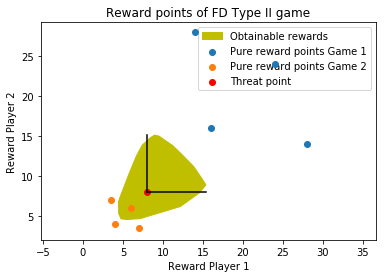

In [30]:
"The first Stochastic Game is based on a Stochastic Game described in the thesis"

p1_1 = np.matrix('16 14; 28 24')
p2_1 = np.matrix('16 28; 14 24')

p1_2 = np.matrix('4 3.5; 7 6')
p2_2 = np.matrix('4 7; 3.5 6')

trans1_1 = np.matrix('0.8 0.7; 0.7 0.6')
trans2_1 = np.matrix('0.5 0.4; 0.4 0.15')

trans1_2 = np.matrix('0.2 0.3; 0.3 0.4')
trans2_2 = np.matrix('0.5 0.6; 0.6 0.85')   

FirstTry = StochasticGame(p1_1,p2_1,p1_2,p2_2,trans1_1,trans2_1,trans1_2,trans2_2)
FirstTry.plot_single_period_pure_rewards()
FirstTry.plot_all_reward_points(True)
# FirstTry.maximin_point(100)
# timing = time.time()
# FirstTry.threat_point_algorithm(100000,0.025)
# now = time.time()
# print(now-timing)
FirstTry.threat_point_optimized(100000,False,False,True,True)
FirstTry.plot_threat_point()
FirstTry.plot_threat_point_lines()
FirstTry.optimized_maximin(100000,False,False,True)




# d1_1 = np.matrix('1 0;0 1')
# d2_1 = np.matrix('1 1;0 1')

# d1_2 = np.matrix('16 0;28 24')
# d2_2 = np.matrix('0 14;12 8')

# SecondTry = StochasticGame(d1_1,d2_1,d1_2,d2_2,trans1_1,trans2_1,trans1_2,trans2_2)
# SecondTry.plot_single_period_pure_rewards()
# SecondTry.plot_convex_hull_pure_rewards()
# SecondTry.plot_all_reward_points()
# SecondTry.maximin_point()
# SecondTry.threat_point_algorithm()
# SecondTry.plot_threat_point()



# e1_1 = np.matrix('10 15; 21 10')
# e1_2 = np.matrix('0 10;3 0')

# e2_1 = np.matrix('1 0;5 5')
# e2_2 = np.matrix('3 4;2 5')

# tre1_1 = np.matrix('0.9999 0.9;0.95 0.85')
# tre2_1 = np.matrix('0.6 0.99;0.75 0.5')

# tre1_2 = np.matrix('0.0001 0.1;0.05 0.15')
# tre2_2 = np.matrix('0.4 0.01;0.25 0.5')

# ThirdTry = StochasticGame(e1_1,e2_1,e1_2,e2_2,tre1_1,tre2_1,tre1_2,tre2_2)
# ThirdTry.plot_single_period_pure_rewards()
# ThirdTry.plot_convex_hull_pure_rewards()
# ThirdTry.plot_all_reward_points()
# ThirdTry.maximin_point()
# ThirdTry.threat_point_algorithm()
# ThirdTry.plot_threat_point()

# f1_1 = np.matrix('10 10; 10 10')
# f1_2 = np.matrix('10 10; 10 10')

# f2_1 = np.matrix('10 10; 10 10')
# f2_2 = np.matrix('10 10; 10 10')

# fre1_1 = np.matrix('0.5 0.5;0.5 0.5')
# fre2_1 = np.matrix('0.5 0.5;0.5 0.5')

# fre1_2 = np.matrix('0.5 0.5;0.5 0.5')
# fre2_2 = np.matrix('0.5 0.5;0.5 0.5')


# Indif = StochasticGame(f1_1,f2_1,f1_2,f2_2,fre1_1,fre2_1,fre1_2,fre2_2)
# Indif.plot_single_period_pure_rewards()
# Indif.plot_convex_hull_pure_rewards()
# Indif.plot_all_reward_points()
# Indif.threat_point_algorithm()
# Indif.plot_threat_point()

# sizex = 10

# TP1_1 = np.random.randint(0,20, size=(sizex,sizex))
# TP1_2 = np.random.randint(0,20, size=(sizex,sizex))

# TP2_1 = np.random.randint(0,20, size=(sizex,sizex))
# TP2_2 = np.random.randint(0,20, size=(sizex,sizex))

# TPTP1_1 = np.matrix(np.random.rand(sizex,sizex))
# TPTP2_1 = np.matrix(np.random.rand(sizex,sizex))

# TPTP1_2 = 1 - TPTP1_1
# TPTP2_2 = 1 - TPTP2_1

# TestGame = StochasticGame(TP1_1,TP2_1,TP1_2,TP2_2,TPTP1_1,TPTP2_1,TPTP1_2,TPTP2_2)
# start = time.time()
# TestGame.maximin_point(1000000)
# print(time.time()-start)

# start = time.time()
# TestGame.threat_point_algorithm(1000000,0.025)
# print(time.time()-start)

# start = time.time()
# TestGame.try_out_optimized_minimax(1000000,False,False,False)
# print(time.time()-start)

# start = time.time()
# TestGame.try_out_optimized(1000000,False,False,True,False)
# print(time.time()-start)


In [15]:

class ETPGame:
    "The ETP Game class represents the Type III games from the thesis, with or without ESP."
    
    def __init__(self,payoff_p1_game1,payoff_p2_game1,payoff_p1_game2,payoff_p2_game2,trmatrixg1,trmatrixg2,trmatrixg3,trmatrixg4,matrixA):
        "Here below we initialize the game by storing payoff and transition matrices according to the upper input."
        self.payoff_p1_game1 = payoff_p1_game1                  #payoff p1 in game 1
        self.payoff_p2_game1 = payoff_p2_game1                  #payoff p2 in game 1
         
        self.payoff_p1_game2 = payoff_p1_game2                  #payoff p1 in game 2
        self.payoff_p2_game2 = payoff_p2_game2                  #payoff p2 in game 2
        
        self.transition_matrix_game1_to1 = trmatrixg1           #transition matrix from game 1 to game 1
        self.transition_matrix_game2_to1 = trmatrixg2           #transition matrix from game 2 to game 1
         
        self.transition_matrix_game1_to2 = trmatrixg3           #transition matrix from game 1 to game 2
        self.transition_matrix_game2_to2 = trmatrixg4           #transition matrix from game 2 to game 2
        
        self.etp_matrix = matrixA
        
        self.printing = False   #set printing to False
        
        self.best_pure_strategies = np.array([[1,0,1,0],[0,1,1,0],[1,0,0,1],[0,1,0,1]])
      
    def plot_single_period_pure_rewards(self):
        "Here we plot the pure rewards possible for a single period"
        
        plt.figure()                                            #create a figure
        payoff_p1_g1_flat = self.payoff_p1_game1.A1             #create a flattend payoff of p1 in game 1
        payoff_p2_g1_flat = self.payoff_p2_game1.A1             #create a flattend payoff of p2 in game 1
        plt.scatter(payoff_p1_g1_flat,payoff_p2_g1_flat, label="Pure reward points Game 1", zorder = 15) #plot payoffs game 1
     
        payoff_p1_g2_flat = self.payoff_p1_game2.A1             #create a flattend payoff of p1 in game 2
        payoff_p2_g2_flat = self.payoff_p2_game2.A1             #and for p2 in game 2
        plt.scatter(payoff_p1_g2_flat,payoff_p2_g2_flat, label="Pure reward points Game 2", zorder = 15)  #plotting this again
        
        plt.xlabel("Reward Player 1")                           #giving the x-axis the label of payoff p1
        plt.ylabel("Reward Player 2")                           #and the payoff of the y-axis is that of p2
        plt.title("Reward points of FD Type III game")      #and we give it a nice titel
        plt.legend()
        
    def plot_convex_hull_pure_rewards(self):
        "Here we plot a convex hull around the pure reward point, therefore resulting in the total possible reward space"
        
        payoff_p1_g1_flat = self.payoff_p1_game1.A1       #store the flattend payoff of p1 game 1
        payoff_p2_g1_flat = self.payoff_p2_game1.A1       #store the flattend payoff of p2 game 1
        
        payoff_p1_g2_flat = self.payoff_p1_game2.A1       #store the flattend payoff of p1 game 2
        payoff_p2_g2_flat = self.payoff_p2_game2.A1       #store the flattend payoff of p2 game 2
        
        payoff_p1_merged = np.concatenate((payoff_p1_g1_flat,payoff_p1_g2_flat))  #merge p1 payoffs
        payoff_p2_merged = np.concatenate((payoff_p2_g1_flat,payoff_p2_g2_flat))  #merge p2 payoffs
        
        all_payoffs = np.array([payoff_p1_merged,payoff_p2_merged])  #create one array of payoffs
        all_payoffs = np.transpose(all_payoffs)                      #and rotate this one
        
        rewards_convex_hull = ConvexHull(all_payoffs)                #retain the convex hull of the payoffs
        plt.fill(all_payoffs[rewards_convex_hull.vertices,0], all_payoffs[rewards_convex_hull.vertices,1], color='k')
        #here above we fill the convex hull in black
       
    def plot_all_rewards(self,FD_yn):
        "This plots all rewards and is based on the algorithm by Llea Samuel"
        "IMPORTANT NOTE!: GAME IS HARDCODED WITHIN THIS FUNCTION, DUE TO TIME ISSUES, ONE SHOULD TAKE THIS INTO MIND"
        
        np.seterr(all='warn',divide='warn') # this is to show some more information on possible errors, can be excluded

        ## HERE BELOW IS HARDCODED GAME INFORMATION
        A1 = np.array([16, 14, 28, 24, 4, 3.5, 7, 6])
        B1 = np.array([16, 28, 14, 24, 4, 7, 3.5, 6])
        p = np.array([0.8, 0.7, 0.7, 0.6, 0.5, 0.4, 0.4, 0.15])
        ## ABOVE IS HARDCODED GAME INFORMATION
        
        # here below we initialize a lot of variables 
        x = np.zeros(8)
        r = np.zeros(8)
        y = np.zeros(8)
        xstar = np.zeros(8)
        x_a = np.zeros(8)
        yp = np.zeros(4)
        yp_not = np.zeros(4)
        v_p1 = np.zeros(8)
        v_p2 = np.zeros(8)
        Q_vec = np.zeros(8)

        T = 100000 # number of points to generate
        payoff_p1 = np.zeros(T) # initialize payoffs for both players
        payoff_p2 = np.zeros(T)
        
        # store the matrix A
        matrixA = np.matrix('0.00 0.0 0.0 0.00 0.0 0.00 0.00 0.00; 0.35 0.3 0.3 0.25 0.2 0.15 0.15 0.05; 0.35 0.3 0.3 0.25 0.2 0.15 0.15 0.05; 0.7 0.6 0.6 0.5 0.4 0.3 0.3 0.1; 0 0 0 0 0 0 0 0; 0.35 0.3 0.3 0.25 0.2 0.15 0.15 0.05; 0.35 0.3 0.3 0.25 0.2 0.15 0.15 0.05; 0.7 0.6 0.6 0.5 0.4 0.3 0.3 0.1')
        
        # loop over the total number of points to generate
        for t in range(0,T):

            ### BEGIN Q-CHECKER #####

            for i in range(0,3):
                r[i] = np.random.beta(0.5,0.5) # generate frequencies

            Norm_val = np.sum(r) # normalize them

            for i in range(0,3):
                x_a[i] = r[i]/Norm_val # normalize and store
            
            # do some more fancy X calculations
            x_b1 = np.array([x_a[0], x_a[2], 0 , 0])
            x_b2 = np.array([x_a[1], 0, 0, 0])
            x_c1 = x_b1[np.random.permutation(x_b1.size)]
            x_c2 = x_b2[np.random.permutation(x_b2.size)]
            
            for i in range(0,8):
                if i < 4:
                    x[i] = x_c1[i]
                else:
                    x[i] = x_c2[i-4]

            # caclulate yi and yi_not
            for i in range(0,4):
                y[i] = x[i]/np.sum(x[0:4])

            for i in range(4,8):
                y[i] = x[i]/np.sum(x[4:8])

            px = p - np.dot(x,matrixA) # calculate px
            
            # start with computing Q
            for w in range(0,4):
                for i in range(0,4):
                    yp[i] = y[i+4]*px[0,i+4]
                    yp_not[i] = y[i]+(1-px[0,i])

                Q = np.sum(yp)/(np.sum(yp_not) + np.sum(yp)) # compute Q
                Q_not = 1-Q
                Q_vec[w] = Q
                
                # adjust frequency vector based on found Q
                for i in range(0,4):
                    xstar[i] = Q*y[i]

                for i in range(4,8):
                    xstar[i] = Q_not*y[i]

                px = p - np.dot(xstar,matrixA) # adjust PX
            
            # apply Aitken's delta squared
            Q_check_1 = Q_vec[0]-((Q_vec[1] - Q_vec[0])**2) / (Q_vec[2] - 2*Q_vec[1] + Q_vec[0])
            Q_check_2 = Q_vec[1]-((Q_vec[2]- Q_vec[1])**2) / (Q_vec[3] - 2*Q_vec[2] + Q_vec[1])
            diff = Q_check_1 - Q_check_2
            
            # if the distribution has not settled, then infinite calculate a new Q
            while diff > abs(1e-8):

                Q_check_1 = Q_check_2
                
                # new calculations of yi
                for i in range(0,4):
                    yp[i] = y[i+4]*px[0,i+4]
                    yp_not[i] = y[i]*(1-px[0,i])

                Q = (np.sum(yp)) / (np.sum(yp_not) + np.sum(yp)) # again calculate Q
                Q_not = 1-Q
                Q_vec[w+1] = Q
                
                # adjust frequency vector X
                for i in range(0,4):
                    xstar[i] = Q*y[i]

                for i in range(4,8):
                    xstar[i] = Q_not*y[i]

                px = p - np.dot(xstar,matrixA) # px calculations
                
                # compute new Q based on aitken's
                Q_check_2 = Q_vec[w-1] - ((Q_vec[w]-Q_vec[w-1])**2)/(Q_vec[w+1] - 2*Q_vec[w] + Q_vec[w-1])
                diff = Q_check_1 - Q_check_2
                w = w+1
            
            # apply FD function if activated
            if FD_yn == True:
                FD = 1-0.25*(xstar[1]+xstar[2])-(1/3)*xstar[3]-(1/2)*(xstar[5] + xstar[6]) - (2/3) * xstar[7]
            else:
                FD = 1 

            # calculate payoffs
            for i in range(0,8):
                v_p1[i] = xstar[i]*A1[i]
                v_p2[i] = xstar[i]*B1[i]
            
            # calculate definitive rewards based on FD function
            payoff_p1[t] = FD*np.sum(v_p1)
            payoff_p2[t] = FD*np.sum(v_p2)
        
        # store maximal payoffs
        self.maximal_payoffs = np.zeros(2)
        self.maximal_payoffs = [np.max(payoff_p1),np.max(payoff_p2)]
    
        all_payoffs = np.array([payoff_p1,payoff_p2])  #payoffs player 1 and and p2 merging
        all_payoffs = np.transpose(all_payoffs)        #transpose for use in convex_hull
        Convex_Hull_Payoffs = ConvexHull(all_payoffs)  #calculate convex_hull of the payoffs
        
        # plot a nice convex hull
        plt.fill(all_payoffs[Convex_Hull_Payoffs.vertices,0], all_payoffs[Convex_Hull_Payoffs.vertices,1], color='y', zorder=5, label="Obtainable rewards")

    
    def plot_threat_point(self):
        "This function plots the threat point if found"
        
        plt.scatter(self.threat_point[0],self.threat_point[1], zorder=10, color = 'r', label='Threat point')
        plt.legend()
        
    def plot_threat_point_lines(self):
        "This function plots lines around the threat point indicating the limits for the NE"
        
        plt.plot([self.threat_point[0],self.threat_point[0]],[self.threat_point[1],self.maximal_payoffs[1]], color='k', zorder=15)
        plt.plot([self.threat_point[0],self.maximal_payoffs[0]],[self.threat_point[1],self.threat_point[1]], color='k', zorder=15)
        plt.axis('equal')
        plt.savefig('TypeIII-FD.png', dpi=400)
        
        
    def aitken_delta_squared(self,q1,q2,q3):
        "This is the Aitken's Delta Squared accelerator"
        
        x3_x2 = np.subtract(q3,q2)
        x2_x1 = np.subtract(q2,q1)
        
        x3_x2_squared = np.power(x3_x2,2)
        denominator = np.subtract(x3_x2,x2_x1)
        
        fraction = np.divide(x3_x2_squared,denominator)
        
        return np.subtract(q3,fraction)
    
        
    def optimized_maximin(self,points,show_strat_p1,show_strat_p2,FD_yn):
        "This is an optimized version for determining the maximin result"
        
        print("Start of the maximin algorithm")        
         
        def random_strategy_draw(points,number_of_actions):
            "This function draws random strategies from a beta distribution, based on the number of points and actions"
            
            # draw some strategies and normalize them
            strategies_drawn = np.random.beta(0.5,0.5,(points,number_of_actions))
            strategies_drawn = strategies_drawn/np.sum(strategies_drawn, axis=1).reshape([points,1])
            
            return strategies_drawn
         
        def frequency_pairs_p1(points,p2_actions,p1_actions,strategies_drawn):
            "Create strategies based on the best replies for player 1"
            
            # store the size of the games
            game_size_1 = self.payoff_p1_game1.size
            game_size_2 = self.payoff_p1_game2.size
            
            # store the actions for game 1 and 2
            p1_actions_game1 = self.payoff_p1_game1.shape[0]
            p1_actions_game2 = self.payoff_p1_game2.shape[0]
            
            # calculate the combination of the actions and a range
            p1_actions_combi = p1_actions_game1*p1_actions_game2
            p1_action_range = np.arange(p1_actions_combi)
            
            # initialize a frequency pair
            frequency_pairs = np.zeros((points*(p1_actions_game1*p1_actions_game2),game_size_1+game_size_2))
            
            # create actions ranges
            p1_act_game1_range = np.arange(p1_actions_game1)
            p1_act_game2_range = np.arange(p1_actions_game2)
            
            # loop over best responses for game 1
            for i in np.nditer(p1_action_range):
                for j in np.nditer(p1_act_game1_range):
                    mod_remain = np.mod(i,p1_actions_game1)
                    frequency_pairs[i*points:(i+1)*points,p1_actions_game1*mod_remain+j] = strategies_drawn[:,j]
            
            # loop over best responses for game 2
            for i in np.nditer(p1_action_range):
                for j in np.nditer(p1_act_game2_range):
                    floor_div = np.floor_divide(i,p1_actions_game2)
                    frequency_pairs[i*points:(i+1)*points,j+game_size_1+(p1_actions_game1*floor_div)] = strategies_drawn[:,p1_actions_game1+j]

            return frequency_pairs
        
        def balance_equation(self,tot_act_ut,tot_act_thr,tot_payoffs_game1,tot_payoffs,frequency_pairs):
            "Calculates the result of the balance equations in order to adjust the frequency pairs"
            
            # store the game sizes
            game_size_1 = self.payoff_p1_game1.size
            game_size_2 = self.payoff_p1_game2.size
            
            # initialize yi, Q and Q_new
            yi = np.zeros((points*(tot_act_thr*tot_act_ut),game_size_1+game_size_2))
            Q = np.zeros((1,points*(tot_act_thr*tot_act_ut)))
            Q_new = np.zeros((1,points*(tot_act_thr*tot_act_ut))) 
            
            # compute yi
            yi[:,0:tot_payoffs_game1] = frequency_pairs[:,0:tot_payoffs_game1]/np.sum(frequency_pairs[:,0:tot_payoffs_game1], axis=1).reshape([points*tot_payoffs_game1,1])
            yi[:,tot_payoffs_game1:tot_payoffs] = frequency_pairs[:,tot_payoffs_game1:tot_payoffs]/np.sum(frequency_pairs[:,tot_payoffs_game1:tot_payoffs], axis=1).reshape([points*(tot_payoffs-tot_payoffs_game1),1])
            
            index_values = np.arange(points*(tot_act_thr*tot_act_ut)) # set a range
            
            # set px range
            p1_px_between = np.asarray(px)
            p1_px = p1_px_between[0]
            
            # loop for 35 iterations
            for i in np.arange(35):
                
                # in the first iteration we calculate the first Q and adjust X
                if i == 0:
                    new_x = p1_px - np.dot(frequency_pairs,self.etp_matrix)

                    upper_part_Q = np.sum(np.multiply(yi[:,tot_payoffs_game1:tot_payoffs],new_x[:,tot_payoffs_game1:tot_payoffs]),axis=1)
                    leftdown_part_Q = np.sum(np.multiply(yi[:,0:tot_payoffs_game1],(1-new_x[:,0:tot_payoffs_game1])),axis=1)
                    rightdown_part_Q = np.sum(np.multiply(yi[:,tot_payoffs_game1:tot_payoffs],new_x[:,tot_payoffs_game1:tot_payoffs]),axis=1)

                    Q_between = upper_part_Q/(leftdown_part_Q+rightdown_part_Q)
                    Q = Q_between
                    
                    frequency_pairs[:,0:tot_payoffs_game1] = (np.multiply(Q,yi[:,0:tot_payoffs_game1]))
                    frequency_pairs[:,tot_payoffs_game1:tot_payoffs] = np.multiply((1-Q),yi[:,tot_payoffs_game1:tot_payoffs])
                
                # here we just calculate Q in order to guarantee stability
                if i > 0 and i < 10:
                    new_x = p1_px - np.dot(frequency_pairs,self.etp_matrix)

                    upper_part_Q = np.sum(np.multiply(yi[:,tot_payoffs_game1:tot_payoffs],new_x[:,tot_payoffs_game1:tot_payoffs]),axis=1)
                    leftdown_part_Q = np.sum(np.multiply(yi[:,0:tot_payoffs_game1],(1-new_x[:,0:tot_payoffs_game1])),axis=1)
                    rightdown_part_Q = np.sum(np.multiply(yi[:,tot_payoffs_game1:tot_payoffs],new_x[:,tot_payoffs_game1:tot_payoffs]),axis=1)

                    Q_between = upper_part_Q/(leftdown_part_Q+rightdown_part_Q)
                    Q = np.hstack((Q,Q_between))
                    
                    frequency_pairs[:,0:tot_payoffs_game1] = (np.multiply(Q[:,i],yi[:,0:tot_payoffs_game1]))
                    frequency_pairs[:,tot_payoffs_game1:tot_payoffs] = np.multiply((1-Q[:,i]),yi[:,tot_payoffs_game1:tot_payoffs])
                
                # here we calculate Q based on aitken's delta squared
                if i == 10:
                    
                    Q_new = self.aitken_delta_squared(Q[:,i-3],Q[:,i-2],Q[:,i-1])
                    nan_org = np.where(np.isnan(Q_new)) # check where there are NaN's
                    nan_indic = nan_org[0]
                    Q_new[nan_indic,:] = Q_between[nan_indic,:] # remove NaN's with last known values
                    
                    Q_old = np.copy(Q_new)
                    
                    Q = np.hstack((Q,Q_new))

                # all remaining iterations are with Aitkens  
                if i > 10:

                    Q_new[index_values,:] = self.aitken_delta_squared(Q[index_values,i-3],Q[index_values,i-2],Q[index_values,i-1])
                    Q_old2 = np.copy(Q_old)
                    nan_res = np.where(np.isnan(Q_new,Q_old)) # check for NaN's
                    nan_indices = nan_res[0] # look where NaN's are
                    
                    # delete values which are NaN for future computations
                    nan_between = np.where(np.in1d(index_values,nan_indices))
                    nan_cands = nan_between[0]
                    index_values = np.delete(index_values,nan_cands)
                    
                    Q_new[nan_indices,:] = Q_old2[nan_indices,:] 
                    
                    Q = np.hstack((Q,Q_new))
                    
                    Q_old = np.copy(Q_new)
                    results = np.where(Q[index_values,i-1] == Q[index_values,i]) # check where convergence has occured
                    remove_indices = results[0]
                    
                    # remove indices which have converged
                    removal_between = np.where(np.in1d(index_values,remove_indices))
                    removal_cands = removal_between[0]
                    index_values = np.delete(index_values,removal_cands)
            
            # compute the definitive frequency pair x
            frequency_pairs[:,0:tot_payoffs_game1] = (np.multiply(Q[:,34],yi[:,0:tot_payoffs_game1]))
            frequency_pairs[:,tot_payoffs_game1:tot_payoffs] = np.multiply((1-Q[:,34]),yi[:,tot_payoffs_game1:tot_payoffs])
            
            return frequency_pairs
        
        def frequency_pairs_p2(points,p2_actions,p1_actions,strategies_drawn):
            "Best responses for P2 based on threaten strategies drawn"
            
            # store the game sizes
            game_size_1 = self.payoff_p2_game1.size
            game_size_2 = self.payoff_p2_game2.size
            
            # store the actions for p1 and p2 and create ranges
            p1_actions_range = np.arange(p1_actions)
            p2_actions_range = np.arange(p2_actions)
            
            p2_actions_game1 = self.payoff_p2_game1.shape[1]
            p2_actions_game2 = self.payoff_p2_game2.shape[1]
            
            p2_actions_combo = p2_actions_game1*p2_actions_game2
            p2_action_range = np.arange(p2_actions_combo)
            
            # initialize the frequency pair
            frequency_pairs = np.zeros((points*(p2_actions_game1*p2_actions_game2),game_size_1+game_size_2))
            
            # generate best responses for game 1
            for i in np.nditer(np.arange(p2_actions_game1)):
                for j in np.nditer(p2_action_range):
                    modul = np.mod(j,p2_actions_game1)
                    frequency_pairs[j*points:(j+1)*points,p2_actions_game1*i+modul] = strategies_drawn[:,i]
            
            # generate best respones for game 2
            for i in np.nditer(np.arange(p2_actions_game2)):
                for j in np.nditer(p2_action_range):
                    divide = np.floor_divide(j,p2_actions_game2)
                    frequency_pairs[j*points:(j+1)*points,p2_actions_combo+divide+(i*p2_actions_game2)] = strategies_drawn[:,i+p2_actions_game1]                 
                    
            return frequency_pairs
        
        def payoffs_sorted(points,payoffs,actions):
            "Sort the payoffs for determination of maximin"
            
            # store the range of points and actions
            points_range = np.arange(points)
            actions_range = np.arange(actions)
        
            payoffs_sort = np.zeros((points,actions)) # initialize the payoffs sort
            
            # sort the payoffs!
            for x in np.nditer(points_range):
                for i in np.nditer(actions_range):
                    payoffs_sort[x,i] = payoffs[points*i+x]
            
            return payoffs_sort
        
        ## Start of p1 maximin ##
        
        start_time = time.time() # START TIME
        
        # flatten the transition matrices
        flatten1_1 = self.transition_matrix_game1_to1.flatten()
        flatten2_1 = self.transition_matrix_game2_to1.flatten()
        
        # store and compute some action stuff
        actions_p2_game1 = self.payoff_p1_game1.shape[1]
        actions_p2_game2 = self.payoff_p1_game2.shape[1]
        total_actions_p2 = actions_p2_game1 + actions_p2_game2
        
        actions_p1_game1 = self.payoff_p1_game1.shape[0]
        actions_p1_game2 = self.payoff_p1_game2.shape[0]
        total_actions_p1 = actions_p1_game1 + actions_p1_game2
        
        # flatten the payoffs
        payoff_p1_game_1flatten = self.payoff_p1_game1.flatten()
        payoff_p1_game_2flatten = self.payoff_p1_game2.flatten()
        
        # compute and store some payoffs stuff
        total_payoffs_p1_game1 = payoff_p1_game_1flatten.size
        total_payoffs_p1_game2 = payoff_p1_game_2flatten.size
        total_payoffs_p1 = total_payoffs_p1_game1 + total_payoffs_p1_game2
        
        payoff_p2_game_1flatten = self.payoff_p2_game1.flatten()
        payoff_p2_game_2flatten = self.payoff_p2_game2.flatten()

        total_payoffs_p2_game1 = payoff_p2_game_1flatten.size
        total_payoffs_p2_game2 = payoff_p2_game_2flatten.size
        total_payoffs_p2 = total_payoffs_p2_game1 + total_payoffs_p2_game2
        
        total_payoffs_p2_game1 = payoff_p2_game_1flatten.size
        total_payoffs_p2_game2 = payoff_p2_game_2flatten.size
        total_payoffs_p2 = total_payoffs_p2_game1 + total_payoffs_p2_game2
        
        # initialize the payoff stuff for p1
        payoff_p1 = np.zeros(total_payoffs_p1)
        payoff_p1[0:total_payoffs_p1_game1] = payoff_p1_game_1flatten
        payoff_p1[total_payoffs_p1_game1:total_payoffs_p1] = payoff_p1_game_2flatten

        px = np.concatenate([flatten1_1,flatten2_1],axis=1) # px for the first time
        
        y_punisher = random_strategy_draw(points,total_actions_p1) # draw some strategies

        frequency_pairs = frequency_pairs_p2(points,total_actions_p1,total_actions_p2,y_punisher) # sort them based on best replies
        
        # do the balance equations with Aitken's
        frequency_pairs = balance_equation(self,actions_p2_game1,actions_p2_game2,total_payoffs_p2_game1,total_payoffs_p2,frequency_pairs)
        
        # activate FD function if necessary
        if FD_yn == True:
            FD = 1-0.25*(frequency_pairs[:,1]+frequency_pairs[:,2])-(1/3)*frequency_pairs[:,3]-(1/2)*(frequency_pairs[:,5] + frequency_pairs[:,6]) - (2/3) * frequency_pairs[:,7]
        else:
            FD = 1     
        
        # calculate the payoffs
        payoffs = np.sum(np.multiply(frequency_pairs,payoff_p1),axis=1)
        payoffs = np.multiply(FD,payoffs)
        payoffs = payoffs.reshape((payoffs.size,1))
        
        max_payoffs = payoffs_sorted(points,payoffs,(actions_p2_game1*actions_p2_game2)) # sort the payoffs

        nan_delete = np.where(np.isnan(max_payoffs)) # delete results which are NaN (see thesis why)

        max_payoffs = np.delete(max_payoffs,nan_delete[0],0) # actually delete these payoffs
        
        print("")
        print("")
        minimax_found = np.nanmax(np.nanmin(max_payoffs,axis=1)) # look for maximin value
        print("Maximin value for P1 is",minimax_found)
        print("")
        print("")
        
        if show_strat_p1 == True:
            minimax_indices_p2 = np.where(max_payoffs == minimax_found)
            found_strategy_p2 = y_punisher[minimax_indices_p2[0]]
            fnd_strategy_p2 = found_strategy_p2.flatten()
            fnd_strategy_p2[0:2] = fnd_strategy_p2[0:2]/np.sum(fnd_strategy_p2[0:2])
            fnd_strategy_p2[2:4] = fnd_strategy_p2[2:4]/np.sum(fnd_strategy_p2[2:4])
            print("Player 1 plays stationary strategy:", fnd_strategy_p2)
            print("While player 2 replies with a best pure reply of:", self.best_pure_strategies[minimax_indices_p2[1]])
            
        end_time = time.time()
        print("Seconds done to generate", points, "points", end_time-start_time)
        
        ## End of P1 maximin algorithm ##
        
        start_time_p2 = time.time() # start the time 
        
        # flatten the payoffs
        payoff_p2_game_1flatten = self.payoff_p2_game1.flatten()
        payoff_p2_game_2flatten = self.payoff_p2_game2.flatten()
        
        # compute and store the payoffs
        total_payoffs_p2_game1 = payoff_p2_game_1flatten.size
        total_payoffs_p2_game2 = payoff_p2_game_2flatten.size
        total_payoffs_p2 = total_payoffs_p2_game1 + total_payoffs_p2_game2
        
        # initialize the payoffs and store them
        payoff_p2 = np.zeros(total_payoffs_p2)
        payoff_p2[0:total_payoffs_p2_game1] = payoff_p2_game_1flatten
        payoff_p2[total_payoffs_p2_game1:total_payoffs_p2] = payoff_p2_game_2flatten

        px = np.concatenate([flatten1_1,flatten2_1],axis=1) # px store

        x_punisher = random_strategy_draw(points,total_actions_p2) # generate new random strategies for punsher
         
        frequency_pairs = frequency_pairs_p1(points,total_actions_p1,total_actions_p2,x_punisher) # best reponses p1
        
        # balance equations with Delta Squared
        frequency_pairs = balance_equation(self,actions_p1_game1,actions_p1_game2,total_payoffs_p1_game1,total_payoffs_p1,frequency_pairs)
        
        # activate FD function if necessary
        if FD_yn == True:
            FD = 1-0.25*(frequency_pairs[:,1]+frequency_pairs[:,2])-(1/3)*frequency_pairs[:,3]-(1/2)*(frequency_pairs[:,5] + frequency_pairs[:,6]) - (2/3) * frequency_pairs[:,7]
        else:
            FD = 1     
        
        # compute the payoffs with payoffs and FD function
        payoffs = np.sum(np.multiply(frequency_pairs,payoff_p2),axis=1)        
        payoffs = np.multiply(FD,payoffs)
        payoffs = payoffs.reshape((payoffs.size,1))
        
        max_payoffs = payoffs_sorted(points,payoffs,(actions_p1_game1*actions_p1_game2)) # sort the payoffs
        
        nan_delete = np.where(np.isnan(max_payoffs)) # check where there are nan's

        max_payoffs = np.delete(max_payoffs,nan_delete[0],0) # delete these nan's
        
        minimax_found_p2 = np.nanmax(np.nanmin(max_payoffs,axis=1)) # find the maximin value for p2
        print("Maximin value for P2 is",minimax_found_p2)
        print("")
        print("")
        

        if show_strat_p2 == True:
            maximin_indices_p2 = np.where(max_payoffs == minimax_found_p2)
            found_strategy = x_punisher[maximin_indices_p2[0]]
            fnd_strategy = found_strategy.flatten()
            fnd_strategy[0:2] = fnd_strategy[0:2]/np.sum(fnd_strategy[0:2])
            fnd_strategy[2:4] = fnd_strategy[2:4]/np.sum(fnd_strategy[2:4])
            print("Player 2 plays stationairy strategy:", fnd_strategy)
            print("While player 2 replies with a best pure reply of:", self.best_pure_strategies[maximin_indices_p2[1]])
        
        end_time_p2 = time.time() # end the timer
        print("Seconds done to generate", points, "points", end_time_p2-start_time_p2)
        print("")
        print("")
       
    def threat_point_optimized(self,points,show_strat_p1,show_strat_p2,print_text,FD_yn):
        "OPtimized threat point algorithm for ETP games"
        
        def random_strategy_draw(points,number_of_actions):
            "This function draws random strategies from a beta distribution, based on the number of points and actions"
            
            # draw some strategies and normalize them
            strategies_drawn = np.random.beta(0.5,0.5,(points,number_of_actions))
            strategies_drawn = strategies_drawn/np.sum(strategies_drawn, axis=1).reshape([points,1])
            
            return strategies_drawn
        
        def frequency_pairs_p1(points,p2_actions,p1_actions,strategies_drawn):
            "This function sorts the strategies based on the responses"
            
            # store the game size
            game_size_1 = self.payoff_p1_game1.size
            game_size_2 = self.payoff_p1_game2.size
            
            # store the actions of p1 in both game
            p1_actions_game1 = self.payoff_p1_game1.shape[0]
            p1_actions_game2 = self.payoff_p1_game2.shape[0]
            
            p1_actions_combi = p1_actions_game1*p1_actions_game2
            p1_action_range = np.arange(p1_actions_combi)
            
            # initialize frequency pairs
            frequency_pairs = np.zeros((points*(p1_actions_game1*p1_actions_game2),game_size_1+game_size_2))
            
            # set the range for both games
            p1_act_game1_range = np.arange(p1_actions_game1)
            p1_act_game2_range = np.arange(p1_actions_game2)
            
            # create best response for game 1
            for i in np.nditer(p1_action_range):
                for j in np.nditer(p1_act_game1_range):
                    mod_remain = np.mod(i,p1_actions_game1)
                    frequency_pairs[i*points:(i+1)*points,p1_actions_game1*mod_remain+j] = strategies_drawn[:,j]
            
            # loop for best responses for game 2
            for i in np.nditer(p1_action_range):
                for j in np.nditer(p1_act_game2_range):
                    floor_div = np.floor_divide(i,p1_actions_game2)
                    frequency_pairs[i*points:(i+1)*points,j+game_size_1+(p1_actions_game1*floor_div)] = strategies_drawn[:,p1_actions_game1+j]
            return frequency_pairs
         
        def balance_equation(self,tot_act_ut,tot_act_thr,tot_payoffs_game1,tot_payoffs,frequency_pairs):
            "Calculates the result of the balance equations in order to adjust the frequency pairs"
            
            # store the game sizes
            game_size_1 = self.payoff_p1_game1.size
            game_size_2 = self.payoff_p1_game2.size
            
            # initialize yi, Q and Q_new
            yi = np.zeros((points*(tot_act_thr*tot_act_ut),game_size_1+game_size_2))
            Q = np.zeros((1,points*(tot_act_thr*tot_act_ut)))
            Q_new = np.zeros((1,points*(tot_act_thr*tot_act_ut))) 
            
            # compute Yi
            yi[:,0:tot_payoffs_game1] = frequency_pairs[:,0:tot_payoffs_game1]/np.sum(frequency_pairs[:,0:tot_payoffs_game1], axis=1).reshape([points*tot_payoffs_game1,1])
            yi[:,tot_payoffs_game1:tot_payoffs] = frequency_pairs[:,tot_payoffs_game1:tot_payoffs]/np.sum(frequency_pairs[:,tot_payoffs_game1:tot_payoffs], axis=1).reshape([points*(tot_payoffs-tot_payoffs_game1),1])
            
            index_values = np.arange(points*(tot_act_thr*tot_act_ut)) # create a range of index values
            
            p1_px_between = np.asarray(px) # set px
            p1_px = p1_px_between[0]
            
            # iterate for 35 iterations
            for i in np.arange(35):
                
                # first iteration, just calculate Q
                if i == 0:
                    new_x = p1_px - np.dot(frequency_pairs,self.etp_matrix)

                    upper_part_Q = np.sum(np.multiply(yi[:,tot_payoffs_game1:tot_payoffs],new_x[:,tot_payoffs_game1:tot_payoffs]),axis=1)
                    leftdown_part_Q = np.sum(np.multiply(yi[:,0:tot_payoffs_game1],(1-new_x[:,0:tot_payoffs_game1])),axis=1)
                    rightdown_part_Q = np.sum(np.multiply(yi[:,tot_payoffs_game1:tot_payoffs],new_x[:,tot_payoffs_game1:tot_payoffs]),axis=1)

                    Q_between = upper_part_Q/(leftdown_part_Q+rightdown_part_Q)
                    Q = Q_between
                    
                    frequency_pairs[:,0:tot_payoffs_game1] = (np.multiply(Q,yi[:,0:tot_payoffs_game1]))
                    frequency_pairs[:,tot_payoffs_game1:tot_payoffs] = np.multiply((1-Q),yi[:,tot_payoffs_game1:tot_payoffs])
                
                # for stability, calculate until iteration 9 normal Q
                if i > 0 and i < 10:
                    new_x = p1_px - np.dot(frequency_pairs,self.etp_matrix)

                    upper_part_Q = np.sum(np.multiply(yi[:,tot_payoffs_game1:tot_payoffs],new_x[:,tot_payoffs_game1:tot_payoffs]),axis=1)
                    leftdown_part_Q = np.sum(np.multiply(yi[:,0:tot_payoffs_game1],(1-new_x[:,0:tot_payoffs_game1])),axis=1)
                    rightdown_part_Q = np.sum(np.multiply(yi[:,tot_payoffs_game1:tot_payoffs],new_x[:,tot_payoffs_game1:tot_payoffs]),axis=1)

                    Q_between = upper_part_Q/(leftdown_part_Q+rightdown_part_Q)
                    Q = np.hstack((Q,Q_between))
                    
                    frequency_pairs[:,0:tot_payoffs_game1] = (np.multiply(Q[:,i],yi[:,0:tot_payoffs_game1]))
                    frequency_pairs[:,tot_payoffs_game1:tot_payoffs] = np.multiply((1-Q[:,i]),yi[:,tot_payoffs_game1:tot_payoffs])
                
                # apply Aitken's
                if i == 10:
                    
                    Q_new = self.aitken_delta_squared(Q[:,i-3],Q[:,i-2],Q[:,i-1])
                    nan_org = np.where(np.isnan(Q_new)) # check whether Nan's occur
                    nan_indic = nan_org[0]
                    
                    Q_new[nan_indic,:] = Q_between[nan_indic,:] # replace NaN with last known value
                    
                    Q_old = np.copy(Q_new)
                    
                    Q = np.hstack((Q,Q_new))

                # and only Aitken's
                if i > 10:

                    Q_new[index_values,:] = self.aitken_delta_squared(Q[index_values,i-3],Q[index_values,i-2],Q[index_values,i-1])
                    Q_old2 = np.copy(Q_old)
                    nan_res = np.where(np.isnan(Q_new,Q_old)) # check for NaN's
                    nan_indices = nan_res[0]
                    
                    nan_between = np.where(np.in1d(index_values,nan_indices))
                    nan_cands = nan_between[0]
                    
                    index_values = np.delete(index_values,nan_cands) # delete NaN's after being returned in last known
                    
                    Q_new[nan_indices,:] = Q_old2[nan_indices,:]
                    
                    Q = np.hstack((Q,Q_new))
                    
                    Q_old = np.copy(Q_new)
                    results = np.where(Q[index_values,i-1] == Q[index_values,i]) # check whether Q converged
                    remove_indices = results[0]

                    removal_between = np.where(np.in1d(index_values,remove_indices))
                    removal_cands = removal_between[0]
                    index_values = np.delete(index_values,removal_cands)
            
            # compute definitive x
            frequency_pairs[:,0:tot_payoffs_game1] = (np.multiply(Q[:,34],yi[:,0:tot_payoffs_game1]))
            frequency_pairs[:,tot_payoffs_game1:tot_payoffs] = np.multiply((1-Q[:,34]),yi[:,tot_payoffs_game1:tot_payoffs])
        
            return frequency_pairs
       
        def frequency_pairs_p2(points,p2_actions,p1_actions,strategies_drawn):
            "Create frequency pairs for P2 based on best responses"
            
            # store the size of the games
            game_size_1 = self.payoff_p2_game1.size
            game_size_2 = self.payoff_p2_game2.size
            
            # store the ranges of the actions of both players
            p1_actions_range = np.arange(p1_actions)
            p2_actions_range = np.arange(p2_actions)
            
            p2_actions_game1 = self.payoff_p2_game1.shape[1]
            p2_actions_game2 = self.payoff_p2_game2.shape[1]
            
            p2_actions_combo = p2_actions_game1*p2_actions_game2
            p2_action_range = np.arange(p2_actions_combo)
            
            # initialize frequency pairs
            frequency_pairs = np.zeros((points*(p2_actions_game1*p2_actions_game2),game_size_1+game_size_2))
            
            # loop over the first game
            for i in np.nditer(np.arange(p2_actions_game1)):
                for j in np.nditer(p2_action_range):
                    modul = np.mod(j,p2_actions_game1)
                    frequency_pairs[j*points:(j+1)*points,p2_actions_game1*i+modul] = strategies_drawn[:,i]
            # loop over the second game
            for i in np.nditer(np.arange(p2_actions_game2)):
                for j in np.nditer(p2_action_range):
                    divide = np.floor_divide(j,p2_actions_game2)
                    frequency_pairs[j*points:(j+1)*points,p2_actions_combo+divide+(i*p2_actions_game2)] = strategies_drawn[:,i+p2_actions_game1]
                    
            return frequency_pairs
        
        def payoffs_sorted(points,payoffs,actions):
            "This function sorts the payoffs in order to prepare the threat point"
            
            # create ranges for points and actions
            points_range = np.arange(points)
            actions_range = np.arange(actions)
        
            payoffs_sort = np.zeros((points,actions)) # nitialize the payoffs sort
            
            # sort the payoffs!
            for x in np.nditer(points_range):
                for i in np.nditer(actions_range):
                    payoffs_sort[x,i] = payoffs[points*i+x]
            
            return payoffs_sort
        
        if print_text == True:
            print("The start of the algorithm for finding the threat point")
            print("First let's find the threat point for Player 1")

        # flatten the transition matrices
        flatten1_1 = self.transition_matrix_game1_to1.flatten()
        flatten2_1 = self.transition_matrix_game2_to1.flatten()
        
        #  store the actions for both players
        actions_p2_game1 = self.payoff_p1_game1.shape[1]
        actions_p2_game2 = self.payoff_p1_game2.shape[1]
        total_actions_p2 = actions_p2_game1 + actions_p2_game2
        
        actions_p1_game1 = self.payoff_p1_game1.shape[0]
        actions_p1_game2 = self.payoff_p1_game2.shape[0]
        total_actions_p1 = actions_p1_game1 + actions_p1_game2
        
        # Start of algorithm for player 1
        
        start_time = time.time() # timer start
        
        # flatten payoffs game 1 and 2        
        payoff_p1_game_1flatten = self.payoff_p1_game1.flatten()
        payoff_p1_game_2flatten = self.payoff_p1_game2.flatten()
        
        # store size of the payoffs
        total_payoffs_p1_game1 = payoff_p1_game_1flatten.size
        total_payoffs_p1_game2 = payoff_p1_game_2flatten.size
        total_payoffs_p1 = total_payoffs_p1_game1 + total_payoffs_p1_game2
        
        # initialize and assign payoffs
        payoff_p1 = np.zeros(total_payoffs_p1)
        payoff_p1[0:total_payoffs_p1_game1] = payoff_p1_game_1flatten
        payoff_p1[total_payoffs_p1_game1:total_payoffs_p1] = payoff_p1_game_2flatten
        
        px = np.concatenate([flatten1_1,flatten2_1],axis=1) # store px
        
        y_punisher = random_strategy_draw(points,total_actions_p2) # draw strategies for the punisher
              
        frequency_pairs = frequency_pairs_p1(points,total_actions_p2,total_actions_p1,y_punisher) # sort based on best reply
        
        # do the balance equations calculations
        frequency_pairs = balance_equation(self,actions_p1_game1,actions_p1_game2,total_payoffs_p1_game1,total_payoffs_p1,frequency_pairs)
        
        # activate the FD function
        if FD_yn == True:
            FD = 1-0.25*(frequency_pairs[:,1]+frequency_pairs[:,2])-(1/3)*frequency_pairs[:,3]-(1/2)*(frequency_pairs[:,5] + frequency_pairs[:,6]) - (2/3) * frequency_pairs[:,7]
        else:
            FD = 1     
        
        # calculate the payoffs with the frequency pairs and FD function
        payoffs = np.sum(np.multiply(frequency_pairs,payoff_p1),axis=1)
        payoffs = np.multiply(FD,payoffs)
        payoffs = payoffs.reshape((payoffs.size,1))
        
        max_payoffs = payoffs_sorted(points,payoffs,(actions_p1_game1*actions_p1_game2)) # sort the payoffs
        nan_delete = np.where(np.isnan(max_payoffs)) # delete payoffs which are a NaN

        max_payoffs_p1 = np.delete(max_payoffs,nan_delete[0],0) # actually delete them
        threat_point_p1 = np.nanmin(np.nanmax(max_payoffs_p1,axis=1)) # determine the threat point
        
        if print_text == True:
            print("")
            print("")
            print("Threat point value is",threat_point_p1)
            print("")
            print("")
        
        if show_strat_p1 == True:
            threat_point_indices_p1 = np.where(max_payoffs_p1 == threat_point_p1)
            found_strategy_p1 = y_punisher[threat_point_indices_p1[0]]
            fnd_strategy_p1 = found_strategy_p1.flatten()
            fnd_strategy_p1[0:2] = fnd_strategy_p1[0:2]/np.sum(fnd_strategy_p1[0:2])
            fnd_strategy_p1[2:4] = fnd_strategy_p1[2:4]/np.sum(fnd_strategy_p1[2:4])
            print("Player 2 plays stationary strategy:", fnd_strategy_p1)
            print("While player 1 replies with a best pure reply of:", self.best_pure_strategies[threat_point_indices_p1[1]])
            
        end_time = time.time() # stop the time!
        
        if print_text == True:
            print("Seconds done to generate", points, "points", end_time-start_time)
            print("")
        
        # End of algorithm player 1
        
        # Start of algorithm player 2
        
        if print_text == True:
            print("")
            print("")
            print("First start the threat point for player 2")
        start_time_p2 = time.time() # start the time (for p2)
        
        # flatten the payoffs of the gamew
        payoff_p2_game_1flatten = self.payoff_p2_game1.flatten()
        payoff_p2_game_2flatten = self.payoff_p2_game2.flatten()
        
        # check the sizes of the total payoffs
        total_payoffs_p2_game1 = payoff_p2_game_1flatten.size
        total_payoffs_p2_game2 = payoff_p2_game_2flatten.size
        total_payoffs_p2 = total_payoffs_p2_game1 + total_payoffs_p2_game2
        
        # initialize the payoffs for p2 and assign them
        payoff_p2 = np.zeros(total_payoffs_p2)
        payoff_p2[0:total_payoffs_p2_game1] = payoff_p2_game_1flatten
        payoff_p2[total_payoffs_p2_game1:total_payoffs_p2] = payoff_p2_game_2flatten

        px = np.concatenate([flatten1_1,flatten2_1],axis=1) # trix with px

        x_punisher = random_strategy_draw(points,total_actions_p1) # draw some awesome strategies

        frequency_pairs = frequency_pairs_p2(points,total_actions_p2,total_actions_p1,x_punisher) # sort them based on best replies
        
        # do some balance equation accelerator magic
        frequency_pairs = balance_equation(self,actions_p2_game1,actions_p2_game2,total_payoffs_p2_game1,total_payoffs_p2,frequency_pairs)
    
        # if the FD function must be activated, activate it
        if FD_yn == True:
            FD = 1-0.25*(frequency_pairs[:,1]+frequency_pairs[:,2])-(1/3)*frequency_pairs[:,3]-(1/2)*(frequency_pairs[:,5] + frequency_pairs[:,6]) - (2/3) * frequency_pairs[:,7]
        else:
            FD = 1     
        
        # payoffs are calculated
        payoffs = np.sum(np.multiply(frequency_pairs,payoff_p2),axis=1)
        payoffs = np.multiply(FD,payoffs)
        payoffs = payoffs.reshape((payoffs.size,1))
    
        max_payoffs = payoffs_sorted(points,payoffs,(actions_p2_game1*actions_p2_game2)) # awesome sorting process
        nan_delete = np.where(np.isnan(max_payoffs)) # look for NaN's

        max_payoffs_p2 = np.delete(max_payoffs,nan_delete[0],0) # delete them where necessary    
        threat_point_p2 = np.nanmin(np.nanmax(max_payoffs_p2,axis=1)) # determine the threat point
        
        print(payoffs)
        print(np.nanmax(payoffs))
        if print_text == True:
            print("")
            print("")
            print("Threat point value is",threat_point_p2)
            print("")
            print("")
        
        if show_strat_p2 == True:
            threat_point_indices_p2 = np.where(max_payoffs_p2 == threat_point_p2)
            found_strategy = x_punisher[threat_point_indices_p2[0]]
            fnd_strategy = found_strategy.flatten()
            fnd_strategy[0:2] = fnd_strategy[0:2]/np.sum(fnd_strategy[0:2])
            fnd_strategy[2:4] = fnd_strategy[2:4]/np.sum(fnd_strategy[2:4])
            print("Player 1 plays stationairy strategy:", fnd_strategy)
            print("While player 2 replies with a best pure reply of:", self.best_pure_strategies[threat_point_indices_p2[1]])
            
        end_time_p2 = time.time() # stop the time
        
        if print_text == True:
            print("")
            print("Seconds done to generate", points, "points", end_time_p2-start_time_p2)
            print("")
            print("")
        
        self.threat_point = np.zeros(2)
        self.threat_point = [threat_point_p1,threat_point_p2] # store the threat point!
        
        return [threat_point_p1,threat_point_p2]
    

Start of the maximin algorithm


C:\Users\HarmelinkRLA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:229: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\HarmelinkRLA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:229: RuntimeWarning: invalid value encountered in true_divide
C:\Users\HarmelinkRLA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:376: RuntimeWarning: invalid value encountered in multiply
C:\Users\HarmelinkRLA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:377: RuntimeWarning: invalid value encountered in multiply




Maximin value for P1 is 4.45863901112896


Seconds done to generate 100000 points 5.769620895385742
Maximin value for P2 is 4.458709573181736


Seconds done to generate 100000 points 6.140970706939697


The start of the algorithm for finding the threat point
First let's find the threat point for Player 1


C:\Users\HarmelinkRLA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:719: RuntimeWarning: invalid value encountered in multiply
C:\Users\HarmelinkRLA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:720: RuntimeWarning: invalid value encountered in multiply




Threat point value is 4.460099200359857


Player 2 plays stationary strategy: [0.99710076 0.00289924 0.498112   0.501888  ]
While player 1 replies with a best pure reply of: [[0 1 1 0]]
Seconds done to generate 10000 points 0.5405879020690918



First start the threat point for player 2
[[5.77156449]
 [4.71351353]
 [6.51145038]
 ...
 [5.96112274]
 [2.63238176]
 [2.49998949]]
13.608378417700441


Threat point value is 4.45952530703882


Player 1 plays stationairy strategy: [0.91422247 0.08577753 0.80559649 0.19440351]
While player 2 replies with a best pure reply of: [[0 1 1 0]]

Seconds done to generate 10000 points 0.5494990348815918




C:\Users\HarmelinkRLA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:146: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\HarmelinkRLA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:147: RuntimeWarning: invalid value encountered in double_scalars


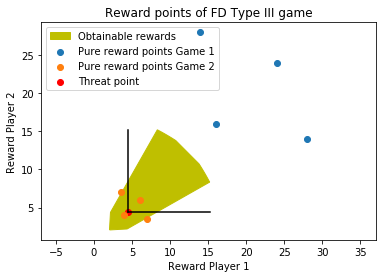

In [16]:
"ETP Example game as described in the thesis, based on a game developed by Llea Samuel"
p1_1 = np.matrix('16 14; 28 24')
p2_1 = np.matrix('16 28; 14 24')

p1_2 = np.matrix('4 3.5; 7 6')
p2_2 = np.matrix('4 7; 3.5 6')

trans1_1 = np.matrix('0.8 0.7; 0.7 0.6')
trans2_1 = np.matrix('0.5 0.4; 0.4 0.15')

trans1_2 = np.matrix('0.2 0.3; 0.3 0.4')
trans2_2 = np.matrix('0.5 0.6; 0.6 0.85')   

matrixA = np.matrix('0.00 0.0 0.0 0.00 0.0 0.00 0.00 0.00; 0.35 0.3 0.3 0.25 0.2 0.15 0.15 0.05; 0.35 0.3 0.3 0.25 0.2 0.15 0.15 0.05; 0.7 0.6 0.6 0.5 0.4 0.3 0.3 0.1; 0 0 0 0 0 0 0 0; 0.35 0.3 0.3 0.25 0.2 0.15 0.15 0.05; 0.35 0.3 0.3 0.25 0.2 0.15 0.15 0.05; 0.7 0.6 0.6 0.5 0.4 0.3 0.3 0.1')
matrixB = np.matrix('0.00 0.0 0.0 0.00 0.0 0.00 0.00 0.00; 0.0 0.0 0.0 0.00 0.0 0.0 0.0 0.00; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0 0 0 0 0 0 0 0; 0.0 0.0 0.0 0.00 0.0 0.00 0.00 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.00; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0')

FirstTryETP = ETPGame(p1_1,p2_1,p1_2,p2_2,trans1_1,trans2_1,trans1_2,trans2_2,matrixA)
FirstTryETP.optimized_maximin(100000,False,False,True)
FirstTryETP.threat_point_optimized(10000,True,True,True,True)
FirstTryETP.plot_single_period_pure_rewards()
FirstTryETP.plot_all_rewards(True)
FirstTryETP.plot_threat_point()
FirstTryETP.plot_threat_point_lines()